# Ross Ice Shelf gravity inversion

## To-Do
* merge grav with AntGG

# Import packages

In [ ]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import pickle
from pathlib import Path

import harmonica as hm
import numpy as np
import pandas as pd
import pygmt
import pyogrio
import verde as vd
import xarray as xr
import zarr
from polartoolkit import fetch, maps, profiles, regions
from polartoolkit import utils as polar_utils
from scipy import stats
import geopandas as gpd
import matplotlib.pyplot as plt

import RIS_gravity_inversion.utils as RIS_utils

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"
logging.getLogger().setLevel(logging.INFO)
from invert4geom import inversion, plotting, regional, utils, uncertainty, cross_validation, optimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set region and parameters

In [22]:
# polygon = regions.draw_region()

Label(value='')

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [79]:
# starting_region = polar_utils.polygon_to_region(polygon)
starting_region = (
    np.float64(129459.93703812482),
    np.float64(406118.83779474284),
    np.float64(-1258693.4882761855),
    np.float64(-957637.5099741525),
)
starting_region

(np.float64(129459.93703812482),
 np.float64(406118.83779474284),
 np.float64(-1258693.4882761855),
 np.float64(-957637.5099741525))

In [86]:
# set layer parameters
layer_spacing = 5e3
registration = "g"

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 5e3

# starting_region = [-580e3, 420e3, -1420e3, -420e3]

def round_to_base(x, base=5):
    return base * round(x/base)
starting_region = [round_to_base(x, base=5e3) for x in starting_region]

inversion_region = starting_region
buffer = 40e3
buffer_region = vd.pad_region(starting_region, buffer)

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# assert buffer width is multiple of layer_spacing
assert buffer % layer_spacing == 0, "buffer is not a multiple of layer_spacing"

# assert valid registration value
assert registration in ["g", "p"]

# assert regions are multiples of spacings
assert [x % layer_spacing for x in starting_region] == [0]*len(starting_region), "starting region is not a multiple of layer_spacing"
assert [x % layer_spacing for x in buffer_region] == [0]*len(buffer_region), "buffer_region is not a multiple of layer_spacing"

layer spacing: 5000.0m
registration: g
inversion region =  [130000.0, 405000.0, -1260000.0, -960000.0]
buffer region =  (90000.0, 445000.0, -1300000.0, -920000.0)


# Load data

## topographic layers
* Surface, Icebase, Bed

From notebook `prepare_grids`

In [25]:
# SURFACE
fname = "../../inversion_layers/bedmachine_surface.zarr"
# fname= "../../inversion_layers/bedmap2_surface.zarr"
surface_full = xr.open_zarr(fname).surface

# ICEBASE
fname = "../../inversion_layers/bedmachine_icebase.zarr"
# fname =  "../../inversion_layers/bedmap2_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase

# BED
fname = "../../inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

fname = "../../inversion_layers/bedmap2_bed.zarr"
bedmap_bed_full = xr.open_zarr(fname).bed

# starting bed
# fname = "../../inversion_layers/bed_from_constraints_verde_spline.zarr"
# fname = "../../inversion_layers/bed_from_constraints_gmt_surface.zarr"
# starting_bed_full = xr.open_zarr(fname).bed

# fname = "../../inversion_layers/RIS_starting_bed_stats.zarr"
# starting_bed_full = xr.open_zarr(fname).weighted_mean

# BASEMENT
# Ross Embayment basement merged to bedmachine bed
# basement = "../../inversion_layers/bed_basement_merged.zarr"
# Ross Embayment basement merged to ANTASed basement
# basement = "../../inversion_layers/ANTASed_magnetics_merged_basement.zarr"
# basement = xr.open_zarr(basement).basement

grids = [
    surface_full,
    icebase_full,
    # starting_bed_full,
    bedmap_bed_full,
    bedmachine_bed_full,
]

for g in grids:
    print(polar_utils.get_grid_info(g))

(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -66.0, 4342.67675781, 'g')
(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -3299.34741211, 4342.60839844, 'g')
(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -5162.05029297, 3722.66943359, 'g')
(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -4501.86767578, 4342.60839844, 'g')


### resample to same spacing / region

In [87]:
surface = fetch.resample_grid(
    surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
icebase = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
# starting_bed = fetch.resample_grid(
#     starting_bed_full,
#     spacing=layer_spacing,
#     region=buffer_region,
#     registration=registration,
#     verbose="q",
# ).rename({"x": "easting", "y": "northing"})
bedmap_bed = fetch.resample_grid(
    bedmap_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmachine_bed = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

# ensure layers never cross
icebase = xr.where(icebase > surface, surface, icebase)
# starting_bed = xr.where(
#     starting_bed > icebase,
#     icebase,
#     starting_bed,
# )

grids = [
    surface,
    icebase,
    # starting_bed,
    bedmap_bed,
    bedmachine_bed,
]

for g in grids:
    print(polar_utils.get_grid_info(g))

INFO:root:spacing larger than original, filtering and resampling
INFO:root:spacing larger than original, filtering and resampling
INFO:root:spacing larger than original, filtering and resampling
INFO:root:spacing larger than original, filtering and resampling


(5000.0, (90000.0, 445000.0, -1300000.0, -920000.0), -52.0, 3051.91040039, 'g')
(5000.0, (90000.0, 445000.0, -1300000.0, -920000.0), -3019.86791992, 3048.90576172, 'g')
(5000.0, (90000.0, 445000.0, -1300000.0, -920000.0), -2567.60693359, 2793.57739258, 'g')
(5000.0, (90000.0, 445000.0, -1300000.0, -920000.0), -3019.86791992, 3048.90576172, 'g')


## bed constraints
from notebook `RIS_bathymetry_data.ipynb`

easting      northing       lat       lon  station_ID  upward  \
0     291621.051176 -1.290527e+06 -77.86667  167.2667           1  -921.0   
1     287588.704471 -1.290120e+06 -77.87833  167.4333           1  -925.0   
3     295701.649410 -1.291101e+06 -77.85333  167.1000           1  -698.0   
5     297701.548871 -1.291204e+06 -77.84834  167.0167           1  -627.0   
16    281534.485687 -1.244032e+06 -78.30000  167.2483          19  -546.0   
38    278922.246136 -1.293706e+06 -77.86333  167.8333           1  -774.0   
42    299746.344783 -1.291483e+06 -77.84167  166.9333           1  -369.0   
84    245542.928381 -1.206882e+06 -78.70000  168.5000          19  -959.0   
97    370320.590763 -1.128547e+06 -79.10000  161.8333          19  -491.0   
131   271689.569780 -1.289259e+06 -77.91666  168.1000           1  -904.0   
176   317077.596007 -9.319585e+05 -80.95778  161.2103          19  -448.0   
307   295257.152344 -1.152732e+06 -79.08000  165.6333           1 -1397.0   
592   330884.677601 -1.142633e+06 -79.08334  163.8500           1 -1026.0   
601   326582.733297 -1.092887e+06 -79.53000  163.3625          19  -834.0   
724   206601.786491 -1.206553e+06 -78.76833  170.2833           1  -680.0   
749   274330.708826 -1.041590e+06 -80.11028  165.2447          19  -834.0   
796   213526.793574 -1.144195e+06 -79.31722  169.4292          19  -740.0   
861   302179.603452 -1.053826e+06 -79.93500  164.0000           1 -1335.0   
886   262443.479330 -1.083545e+06 -79.76527  166.3847          19  -955.0   
1018  307340.144798 -9.819727e+05 -80.55055  162.6208          19  -877.0   
1031  259737.741156 -1.162000e+06 -79.07333  167.4000           1  -926.0   
1085  242801.567307 -1.270798e+06 -78.13333  169.1833           1  -920.0   
1138  274637.921820 -1.092032e+06 -79.66333  165.8833           1 -1129.0   
1161  275187.755301 -9.255234e+05 -81.13028  163.4411          19  -918.0   
1225  160440.517998 -1.140424e+06 -79.42944  171.9919          19  -549.0   
1250  249201.416991 -1.276084e+06 -78.07500  168.9500           1  -902.0   
1277  196652.318700 -1.154503e+06 -79.25166  170.3333           1  -905.0   
1278  313996.001426 -1.132233e+06 -79.21667  164.5000          19 -1149.0   
1300  223931.065323 -1.172032e+06 -79.05000  169.1833           1  -925.0   
1311  108350.891090 -1.200043e+06 -78.94334  174.8408          19  -482.0   
1343  216463.844340 -1.244552e+06 -78.41167  170.1333           1  -815.0   
1387  256910.452033 -1.281834e+06 -78.01000  168.6667           1  -887.0   
1404  175955.794953 -1.006449e+06 -80.61667  170.0833           1  -581.0   
1453  185174.994996 -1.083318e+06 -79.91000  170.3000           1  -562.0   
1511  213735.398525 -9.247073e+05 -81.28111  166.9853          19  -635.0   
1524  161048.314334 -1.201673e+06 -78.87500  172.3667           1  -871.0   
1547  217190.824294 -1.096894e+06 -79.73500  168.8000          19  -694.0   
1572  264577.987681 -1.285131e+06 -77.96667  168.3667           1  -836.0   
1619  217668.052893 -1.252913e+06 -78.33472  170.1444          19  -845.0   
1629  163967.046095 -1.251597e+06 -78.42028  172.5364          19  -841.0   
1712  176771.945507 -1.231783e+06 -78.58334  171.8333          19  -909.0   
1754  273961.609072 -9.795698e+05 -80.65833  164.3750          19  -795.0   
1766  107998.078481 -1.143736e+06 -79.45528  174.6058          19  -521.0   
1770  162724.979104 -9.313355e+05 -81.31445  170.0892          19  -749.0   
1801  153778.289775 -9.442341e+05 -81.21167  170.7500           1  -742.0   
1803  159438.085718 -1.084545e+06 -79.93584  171.6369          19  -570.0   
1836  109569.473139 -1.036965e+06 -80.42445  173.9683          19  -729.0   
1852  158258.721389 -9.454634e+05 -81.19389  170.4975          19  -727.0   
1861  164711.226817 -1.034139e+06 -80.38389  170.9503          19  -574.0   
1866  111676.752545 -1.254404e+06 -78.44695  174.9125          19  -781.0   
1870  108047.340104 -1.194934e+06 -78.99000  174.8333           1  -502.0   
1887  19

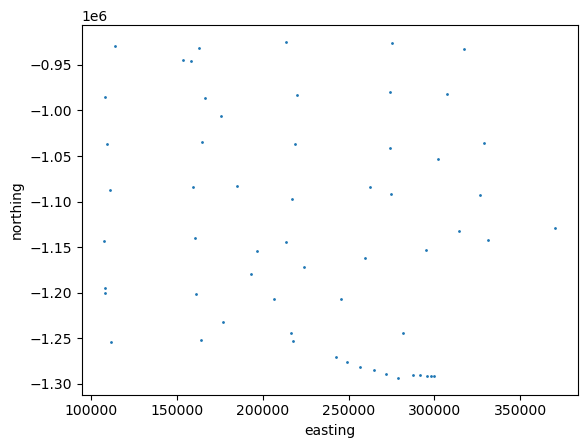

In [88]:
fname = "../../data/bedmap1.csv.gz"
inside_points = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inside_points = inside_points.rename(
    columns={"x": "easting", "y": "northing", "z_ellipsoidal": "upward"}
)

# only keep points within the buffer region
inside_points = polar_utils.points_inside_region(
    inside_points,
    buffer_region,
    names=("easting", "northing"),
)

# get points within RIS
RIS_outline = pyogrio.read_dataframe("../../plotting/RIS_outline.shp")
gdf = gpd.GeoDataFrame(
    inside_points,
    geometry=gpd.points_from_xy(x=inside_points.easting, y=inside_points.northing),
    crs="EPSG:3031",
)
inside_points["inside"] = gdf.within(RIS_outline.geometry[0])
inside_points = inside_points[inside_points["inside"]]
inside_points["buffer"]=False

# sample ice surface elevation into dataframe
# from bedmachine,
inside_points = utils.sample_grids(
    inside_points,
    surface_full,
    "surface_z_ellipsoidal",
    coord_names=["easting", "northing"],
)

# calculate error as 5% of depth from surface
depth = inside_points.surface_z_ellipsoidal - inside_points.upward
uncert = 0.05 * depth
inside_points.loc[inside_points.index, "uncert"] = uncert

inside_points.plot.scatter(x="easting", y="northing", s=1)
inside_points

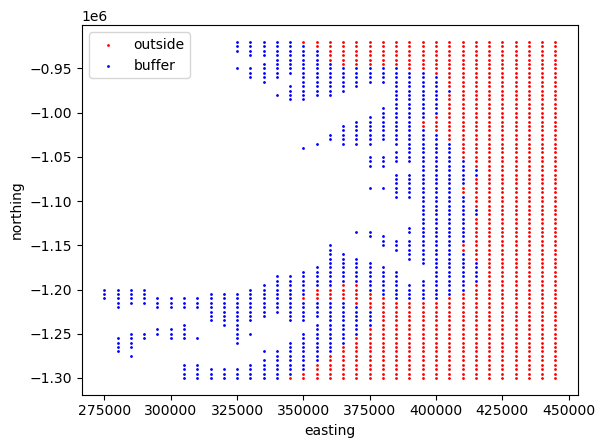

In [89]:
outside_points = RIS_utils.get_buffer_points(
    buffer_width=20e3,
    grid=bedmachine_bed,
    mask=RIS_outline,
    plot=True,
)
outside_points["uncert"]=10

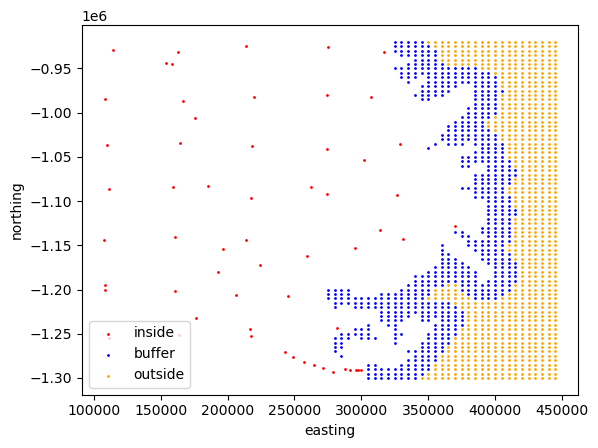

easting      northing       lat       lon  station_ID  \
0     291621.051176 -1.290527e+06 -77.86667  167.2667         1.0   
1     287588.704471 -1.290120e+06 -77.87833  167.4333         1.0   
3     295701.649410 -1.291101e+06 -77.85333  167.1000         1.0   
5     297701.548871 -1.291204e+06 -77.84834  167.0167         1.0   
16    281534.485687 -1.244032e+06 -78.30000  167.2483        19.0   
...             ...           ...       ...       ...         ...   
5539  425000.000000 -9.200000e+05       NaN       NaN         NaN   
5540  430000.000000 -9.200000e+05       NaN       NaN         NaN   
5541  435000.000000 -9.200000e+05       NaN       NaN         NaN   
5542  440000.000000 -9.200000e+05       NaN       NaN         NaN   
5543  445000.000000 -9.200000e+05       NaN       NaN         NaN   

           upward  z_geoidal  z_error  measurement_type  inside  buffer  \
0     -921.000000        NaN      NaN               NaN    True   False   
1     -925.000000        NaN      NaN               NaN    True   False   
3     -698.000000        NaN      NaN               NaN    True   False   
5     -627.000000        NaN      NaN               NaN    True   False   
16    -546.000000        NaN      NaN               NaN    True   False   
...           ...        ...      ...               ...     ...     ...   
5539 -2201.905029        NaN      NaN               NaN   False   False   
5540  -885.510986        NaN      NaN               NaN   False   False   
5541  -207.096878        NaN      NaN               NaN   False   False   
5542   189.716537        NaN      NaN               NaN   False   False   
5543   178.565643        NaN      NaN               NaN   False   False   

      surface_z_ellipsoidal     uncert   weights  
0                -47.547371  43.672631  0.000524  
1                -43.813486  44.059326  0.000515  
3                -51.449440  32.327528  0.000957  
5                -51.909290  28.754535  0.001209  
16               -35.457268  25.527137  0.001535  
...                     ...        ...       ...  
5539                    NaN  10.000000  0.010000  
5540                    NaN  10.000000  0.010000  
5541                    NaN  10.000000  0.010000  
5542                    NaN  10.000000  0.010000  
5543                    NaN  10.000000  0.010000  

[1541 rows x 14 columns]

In [90]:
# merge into 1 dataframe
constraints = pd.concat((inside_points, outside_points))

# calculate weights
constraints["weights"] = 1 / (constraints.uncert ** 2)

# ensure all points are within buffer region
constraints = polar_utils.points_inside_region(
    constraints,
    buffer_region,
    names=("easting", "northing"),
)

constraints[constraints.inside].plot.scatter(x="easting", y="northing", s=1, c='r', label="inside")
constraints[constraints.buffer].plot.scatter(x="easting", y="northing", s=1, c='b', label="buffer", ax=plt.gca())
constraints[(~constraints.buffer) & (~constraints.inside)].plot.scatter(x="easting", y="northing", s=1, c='orange', label="outside", ax=plt.gca())

plt.legend()
plt.show()

constraints

In [91]:
print("Number of constraints inside RIS:", len(constraints[constraints.inside]))

Number of constraints inside RIS: 59


## starting topography

INFO:invert4geom:Best SplineCV score: 0.9020109900696923
INFO:invert4geom:Best damping: 1e-20


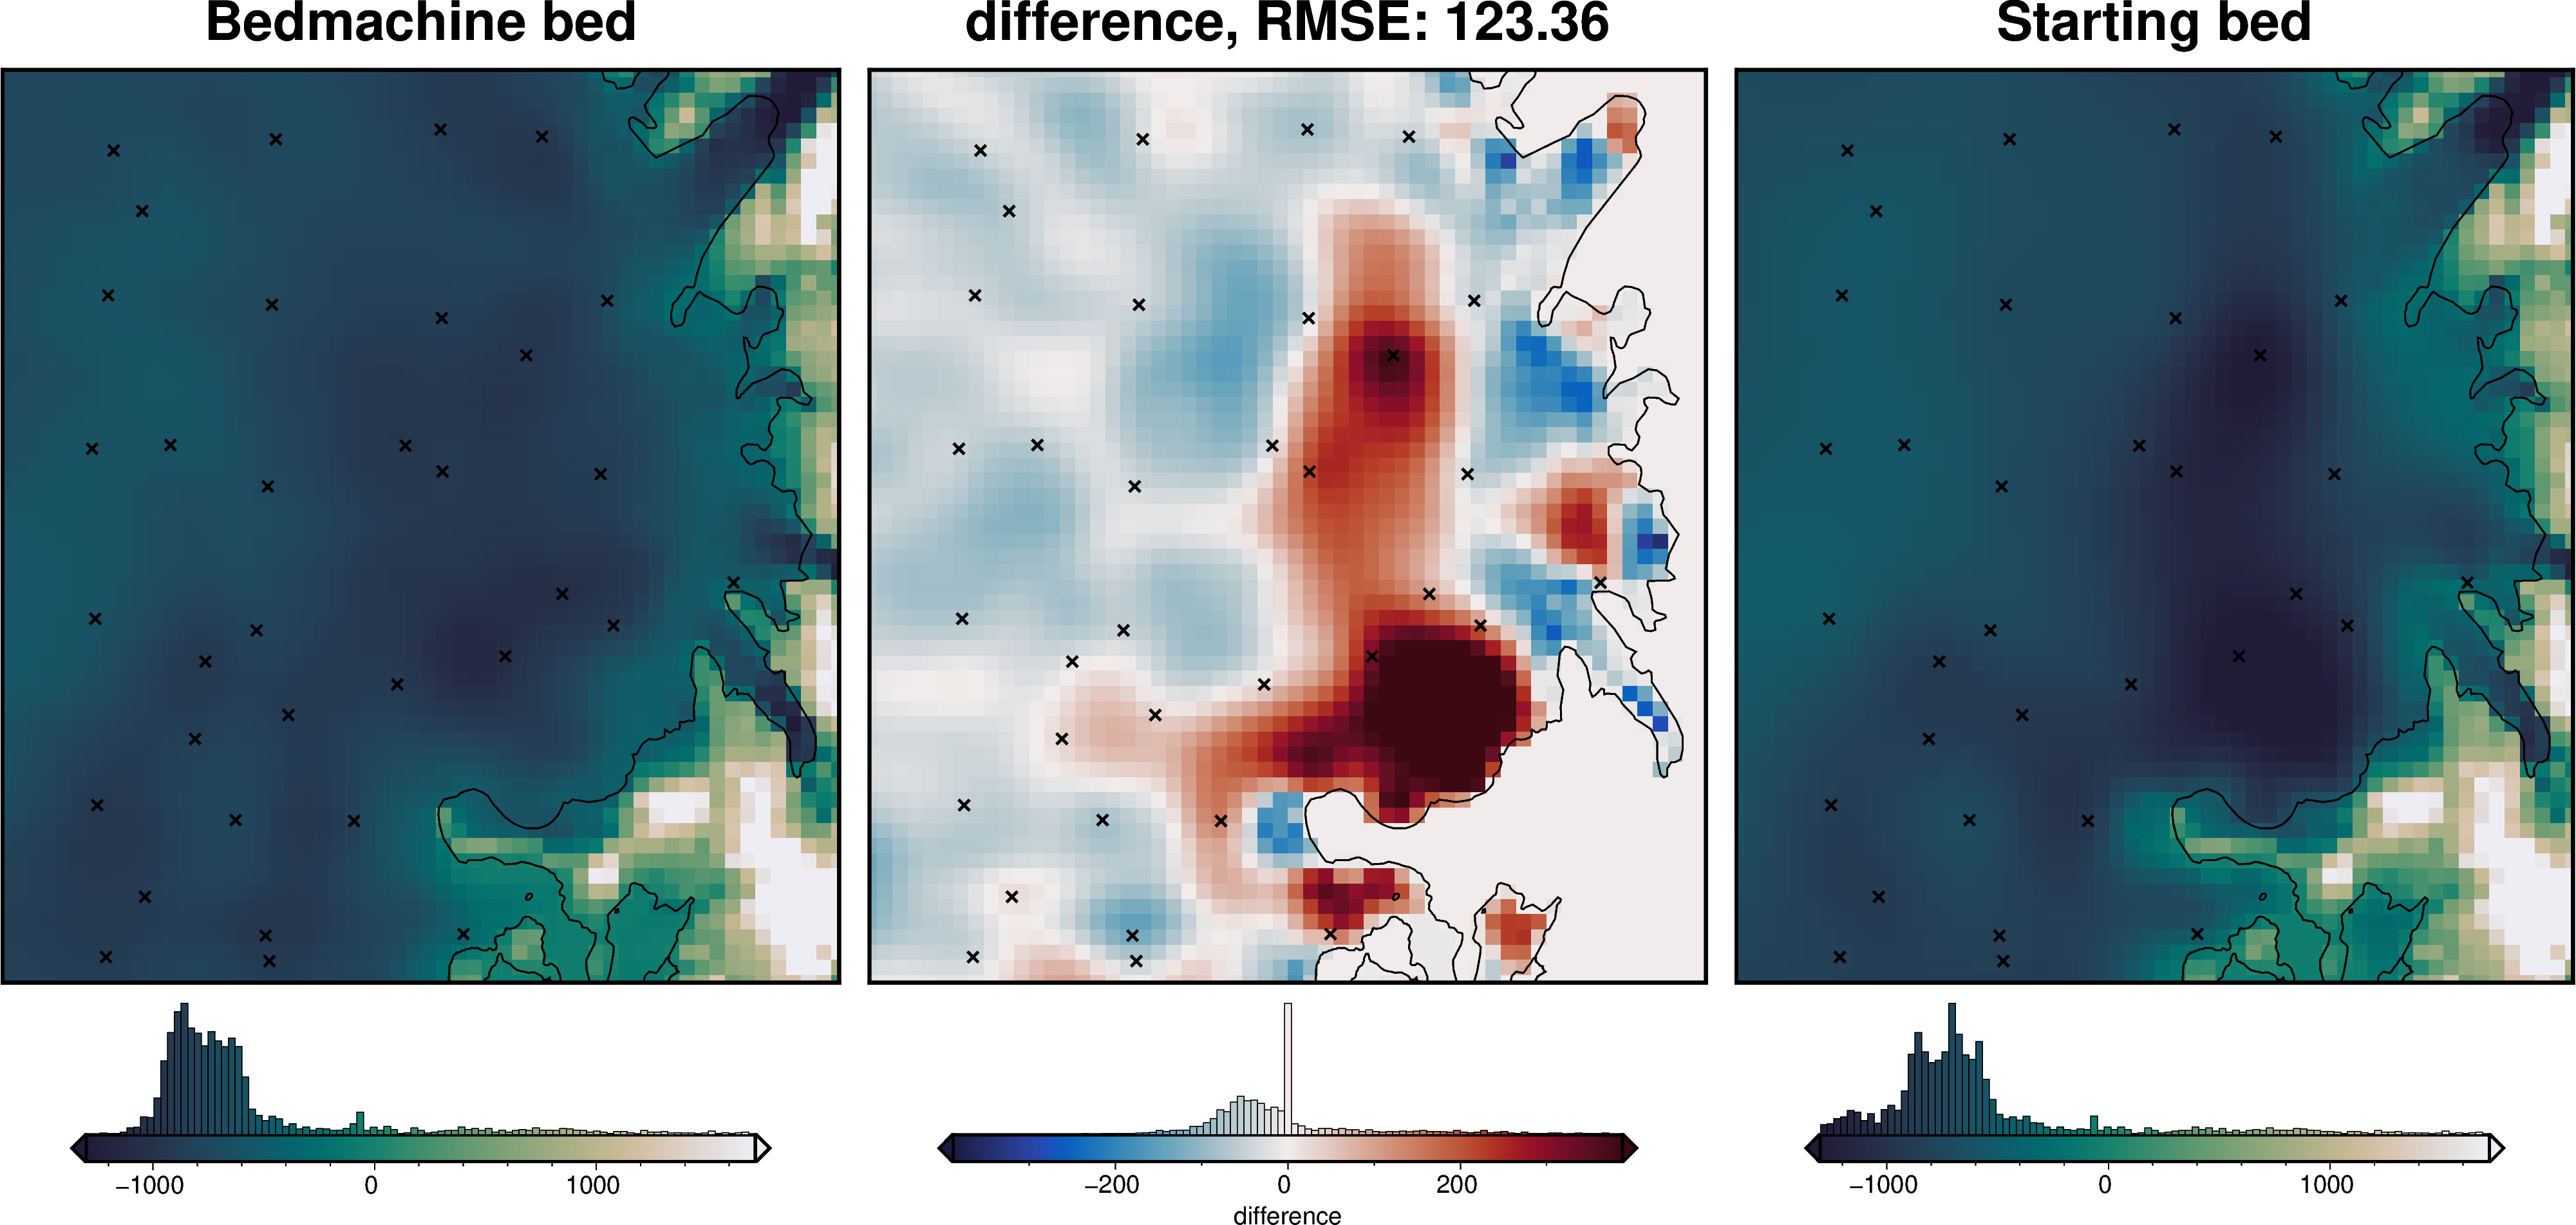

In [139]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=layer_spacing,
    constraints_df=constraints,
    weights_col="weights",
    dampings=[1e-20, 1e-16, 1e-12, 1e-8],
    # dampings=None,"
    upper_confining_layer=icebase,
)
starting_bed = utils.create_topography(**starting_topography_kwargs)

# compare starting bed to bedmachine bed
_ = polar_utils.grd_compare(
    bedmachine_bed,
    starting_bed,
    region=inversion_region,
    plot=True,
    grid1_name="Bedmachine bed",
    grid2_name="Starting bed",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    coast=True,
    coast_version="measures-v2",
    reverse_cpt=True,
    cmap="rain",
    points=constraints[constraints.inside],
    points_style="x.2c",
)

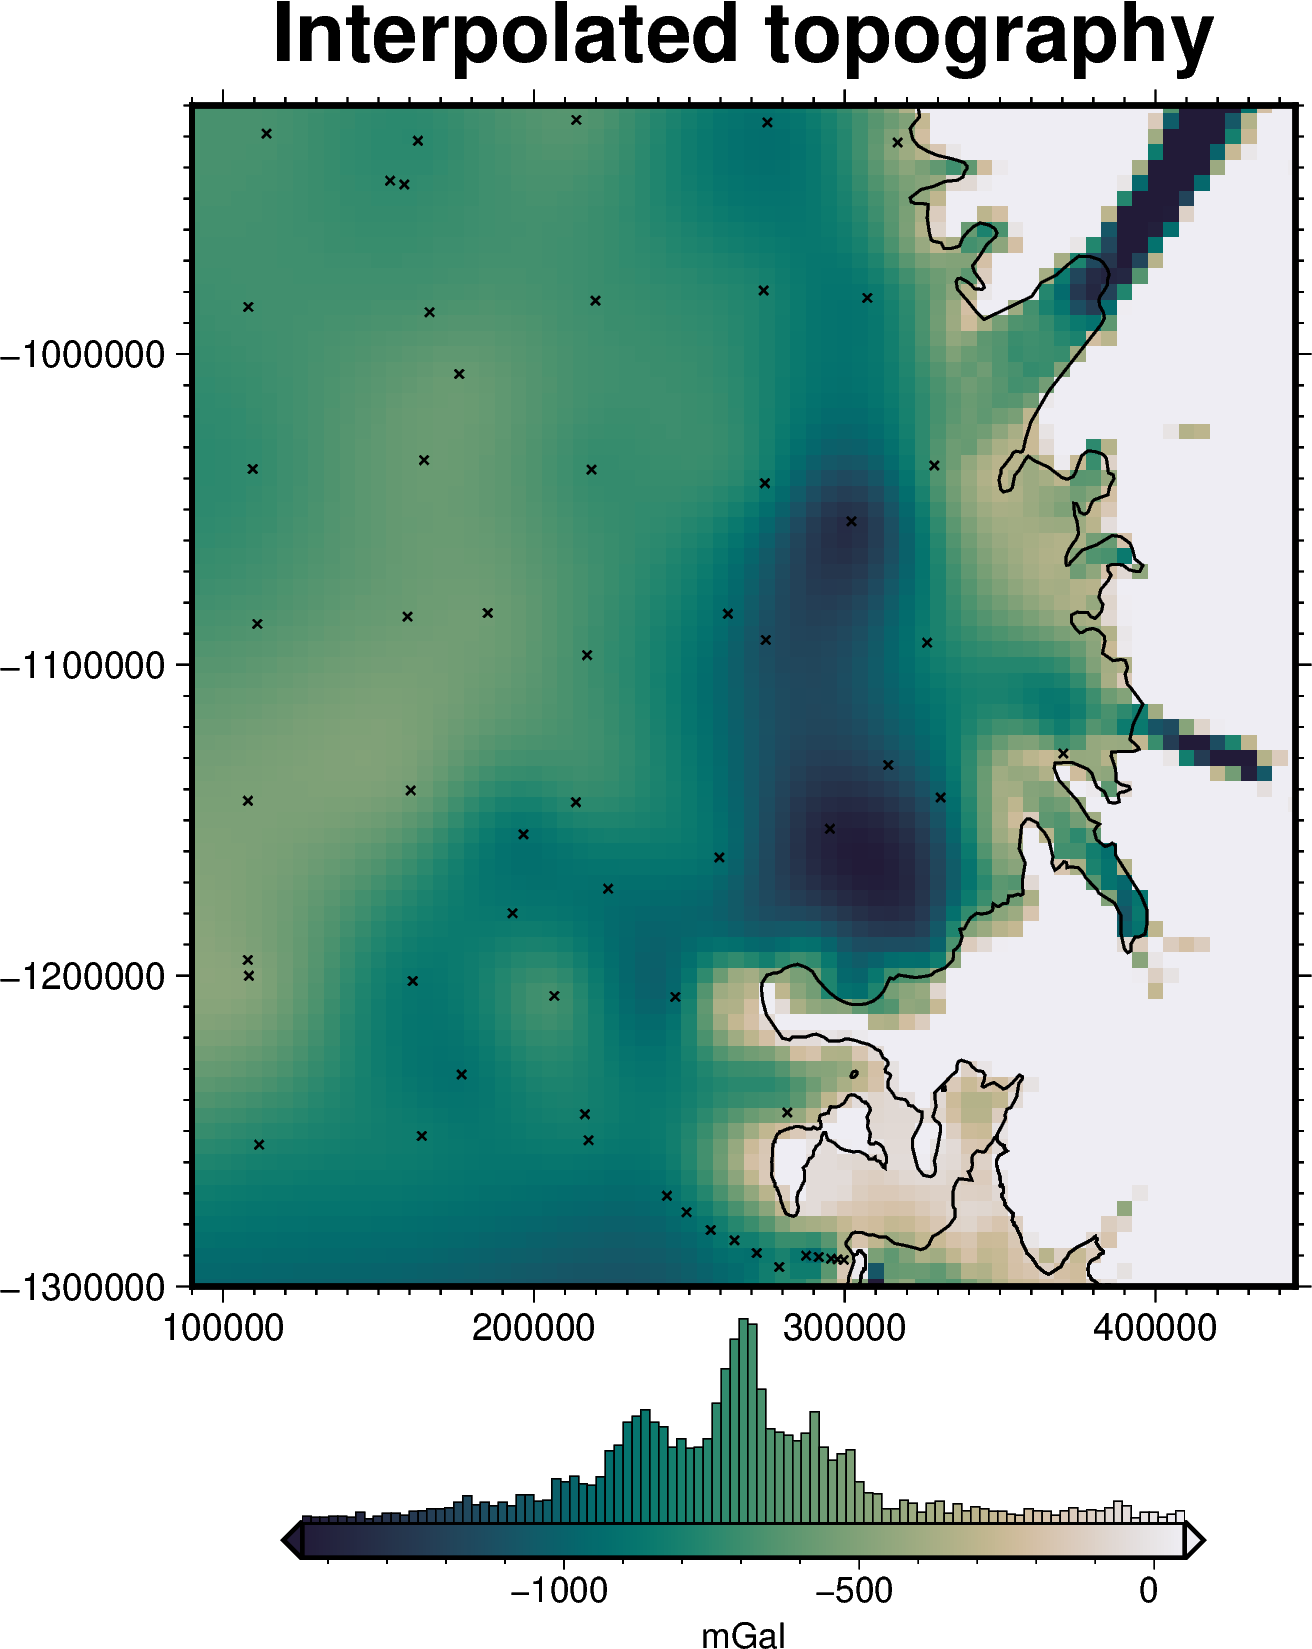

In [140]:
fig = maps.plot_grd(
    starting_bed,
    fig_height=10,
    title="Interpolated topography",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    hist=True,
    # robust=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=constraints[constraints.inside],
    points_style="x.1c",
    points_pen=".5p",
    shp_mask=RIS_outline,
    coast=True,
    coast_version="measures-v2",
)
fig.show()

In [141]:
# sample the inverted topography at the constraint points
constraints = utils.sample_grids(
    constraints,
    starting_bed,
    "starting_bed",
    coord_names=("easting", "northing"),
)
constraints["dif"] = constraints.upward - constraints.starting_bed
rmse = utils.rmse(constraints.upward - constraints.starting_bed)
print(f"RMSE: {rmse:.2f} m")
constraints.describe()

RMSE: 2.98 m


easting      northing        lat         lon  station_ID  \
count    1541.000000  1.541000e+03  59.000000   59.000000   59.000000   
mean   386324.706105 -1.123571e+06 -79.415909  168.707234   11.067797   
std     51310.593522  1.211010e+05   1.103568    3.520734    9.013141   
min    107998.078481 -1.300000e+06 -81.400000  161.210300    1.000000   
25%    365000.000000 -1.230000e+06 -80.325280  166.959300    1.000000   
50%    395000.000000 -1.145000e+06 -79.251660  168.800000   19.000000   
75%    420000.000000 -1.010000e+06 -78.433615  170.725000   19.000000   
max    445000.000000 -9.200000e+05 -77.841670  174.912500   19.000000   

            upward  z_geoidal  z_error  measurement_type  \
count  1541.000000        0.0      0.0               0.0   
mean    588.146430        NaN      NaN               NaN   
std     899.437687        NaN      NaN               NaN   
min   -3019.867920        NaN      NaN               NaN   
25%      31.629709        NaN      NaN               NaN   
50%     631.270691        NaN      NaN               NaN   
75%    1211.190552        NaN      NaN               NaN   
max    3048.905762        NaN      NaN               NaN   

       surface_z_ellipsoidal       uncert      weights          dif  \
count              59.000000  1541.000000  1541.000000  1541.000000   
mean              -17.545359    11.074426     0.009650    -0.023829   
std                13.745989     5.740420     0.001756     2.982101   
min               -51.909290    10.000000     0.000205   -99.510698   
25%               -19.042329    10.000000     0.010000     0.000000   
50%               -14.336784    10.000000     0.010000     0.000000   
75%               -10.781826    10.000000     0.010000     0.000000   
max                12.107692    69.763951     0.010000    20.529280   

       inverted_topography  starting_bed  
count          1541.000000   1541.000000  
mean            559.480132    588.170259  
std             934.782832    899.296418  
min           -3019.858154  -3019.867920  
25%               1.175703     31.474306  
50%             619.510864    631.270691  
75%            1211.139404   1211.190552  
max            3047.715332   3048.905762

## gravity data

partial_topo_corrected_disturbance: disturbance corrected for ice surface and water surface 
starting_bed_grav: forward gravity of starting bed
misfit: partial topo-corrected disturbance - starting bed grav
reg: regional component of misfit
res: residual component of misfit

In [142]:
rosetta_levelled = pd.read_csv(
    "../../data/ROSETTA_2nd_order_levelled.csv.gz",  # up continued and levelled
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# only keep points within the inversion region
rosetta_levelled = polar_utils.points_inside_region(
    rosetta_levelled,
    inversion_region,
    names=("easting", "northing"),
)
# rename second to last column to "disturbance"
col = list(rosetta_levelled.columns)[-2]
rosetta_levelled = rosetta_levelled.rename(columns={col: "disturbance"})

# drop unnecessary columns
cols_to_keep = ["disturbance", "easting", "northing", "line", "Height"]
rosetta_levelled = rosetta_levelled.filter(cols_to_keep)

rosetta_levelled = rosetta_levelled.dropna(subset="disturbance")
rosetta_levelled.describe()

disturbance        easting      northing         line  Height
count  4003.000000    4003.000000  4.003000e+03  4003.000000  4003.0
mean    -36.042567  233243.705738 -1.099224e+06   721.419885  1000.0
std      11.239939   61181.698258  8.492330e+04   177.973148     0.0
min     -76.035062  130084.215062 -1.259764e+06   530.000000  1000.0
25%     -42.040321  183317.505336 -1.160539e+06   600.000000  1000.0
50%     -34.493210  222082.958504 -1.098646e+06   670.000000  1000.0
75%     -28.372331  280882.742650 -1.024368e+06   780.000000  1000.0
max       9.553011  371296.853790 -9.604713e+05  1140.000000  1000.0

In [14]:
# rosetta_levelled["zscore"] = np.abs(stats.zscore(rosetta_levelled.disturbance))
# rosetta_levelled = rosetta_levelled.sort_values(by="zscore", ascending=False)
# ax = rosetta_levelled.zscore.hist(bins=100)
# ax.set_xlim(0, 4)

In [15]:
# # dropped base on z-score
# df_cleaned = rosetta_levelled[rosetta_levelled.zscore < 2.5].copy()
# df_outliers = rosetta_levelled[rosetta_levelled.zscore >= 2.5].copy()

# print("Length of original data:", len(rosetta_levelled))
# print("Length of cleaned data:", len(df_cleaned))

# ax = df_cleaned.zscore.hist(bins=100)
# ax.set_xlim(0, 4)

In [16]:
# # plot a basemap
# fig = maps.basemap(
#     inversion_region,
#     title="Outliers",
# )

# maxabs = max(np.abs(polar_utils.get_min_max(df_outliers.disturbance, robust=True)))
# pygmt.makecpt(cmap="viridis", series=[-maxabs, maxabs])

# # plot gravity data
# fig.plot(
#     x=df_outliers.easting,
#     y=df_outliers.northing,
#     fill=df_outliers.disturbance,
#     style="c6p",
#     cmap=True,
# )

# # plot the colorbar
# fig.colorbar(frame='af+l"free air gravity [mGal]"')

# # add a second figure to the right
# fig = maps.basemap(
#     inversion_region,
#     title="Outliers removed",
#     origin_shift="x",
#     fig=fig,
# )

# # get a quarter of max absolute value and make a colorscale
# maxabs = max(np.abs(polar_utils.get_min_max(df_cleaned.disturbance, robust=True)))
# pygmt.makecpt(cmap="viridis", series=[-maxabs, maxabs])

# # plot gravity data
# fig.plot(
#     x=df_cleaned.easting,
#     y=df_cleaned.northing,
#     fill=df_cleaned.disturbance,
#     style="c2p",
#     cmap=True,
# )

# # plot the colorbar
# fig.colorbar(frame='af+l"free air gravity [mGal]"')

# fig.show()

In [143]:
# coords = (
#     df_cleaned.easting,
#     df_cleaned.northing,
#     df_cleaned.Height,
# )
# data = df_cleaned.disturbance
coords = (
    rosetta_levelled.easting,
    rosetta_levelled.northing,
    rosetta_levelled.Height,
)
data = rosetta_levelled.disturbance

eqs = hm.EquivalentSources(
    damping=1,
    depth="default",
    block_size=grav_spacing,
)
eqs.fit(coords, data)

EquivalentSources(block_size=5000.0, damping=1)

In [144]:
# Define grid coordinates
# region = vd.pad_region(vd.get_region(coords), 25e3)
grid_coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=grav_spacing,
    pixel_register=False,
    extra_coords=1e3,  # upward continue to 1km
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (grid_coords[0], grid_coords[1]),
    data=grid_coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["Gobs"] = eqs.predict((grav_df.easting, grav_df.northing, grav_df.upward))


# mask on distance to nearest data point
grav_df["masked"] = vd.distance_mask(
    (coords[0], coords[1]),
    maxdist=20e3,
    coordinates=(grav_df.easting, grav_df.northing),
)
grav_df = grav_df[grav_df.masked].drop(columns="masked")

# mask with convex hull
# grav_df["masked"] = vd.convexhull_mask(
#     data_coordinates=(df_cleaned.easting, df_cleaned.northing),
#     coordinates=(grav_df.easting, grav_df.northing),
# )
# grav_df = grav_df[grav_df.masked].drop(columns="masked")

# # subset gravity to just within ice shelf border
# RIS_outline = pyogrio.read_dataframe("../../plotting/RIS_outline.shp")
# grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
# # mask grav outside of RIS
# grav_grid["inside"] = polar_utils.mask_from_shp(
#     shapefile=RIS_outline,  # .buffer(10e3),
#     xr_grid=grav_grid.Gobs,
#     masked=False,
#     invert=False,
# )
# grav_df = vd.grid_to_table(grav_grid)
# grav_df = grav_df[grav_df.inside]

grav_df.describe()

northing        easting  upward         Gobs
count  2.704000e+03    2704.000000  2704.0  2704.000000
mean  -1.099945e+06  241294.378698  1000.0   -35.588608
std    8.304406e+04   68359.346468     0.0    11.465488
min   -1.260000e+06  130000.000000  1000.0   -75.078904
25%   -1.165000e+06  185000.000000  1000.0   -41.720980
50%   -1.095000e+06  240000.000000  1000.0   -33.978558
75%   -1.030000e+06  295000.000000  1000.0   -27.799534
max   -9.600000e+05  390000.000000  1000.0     2.948951

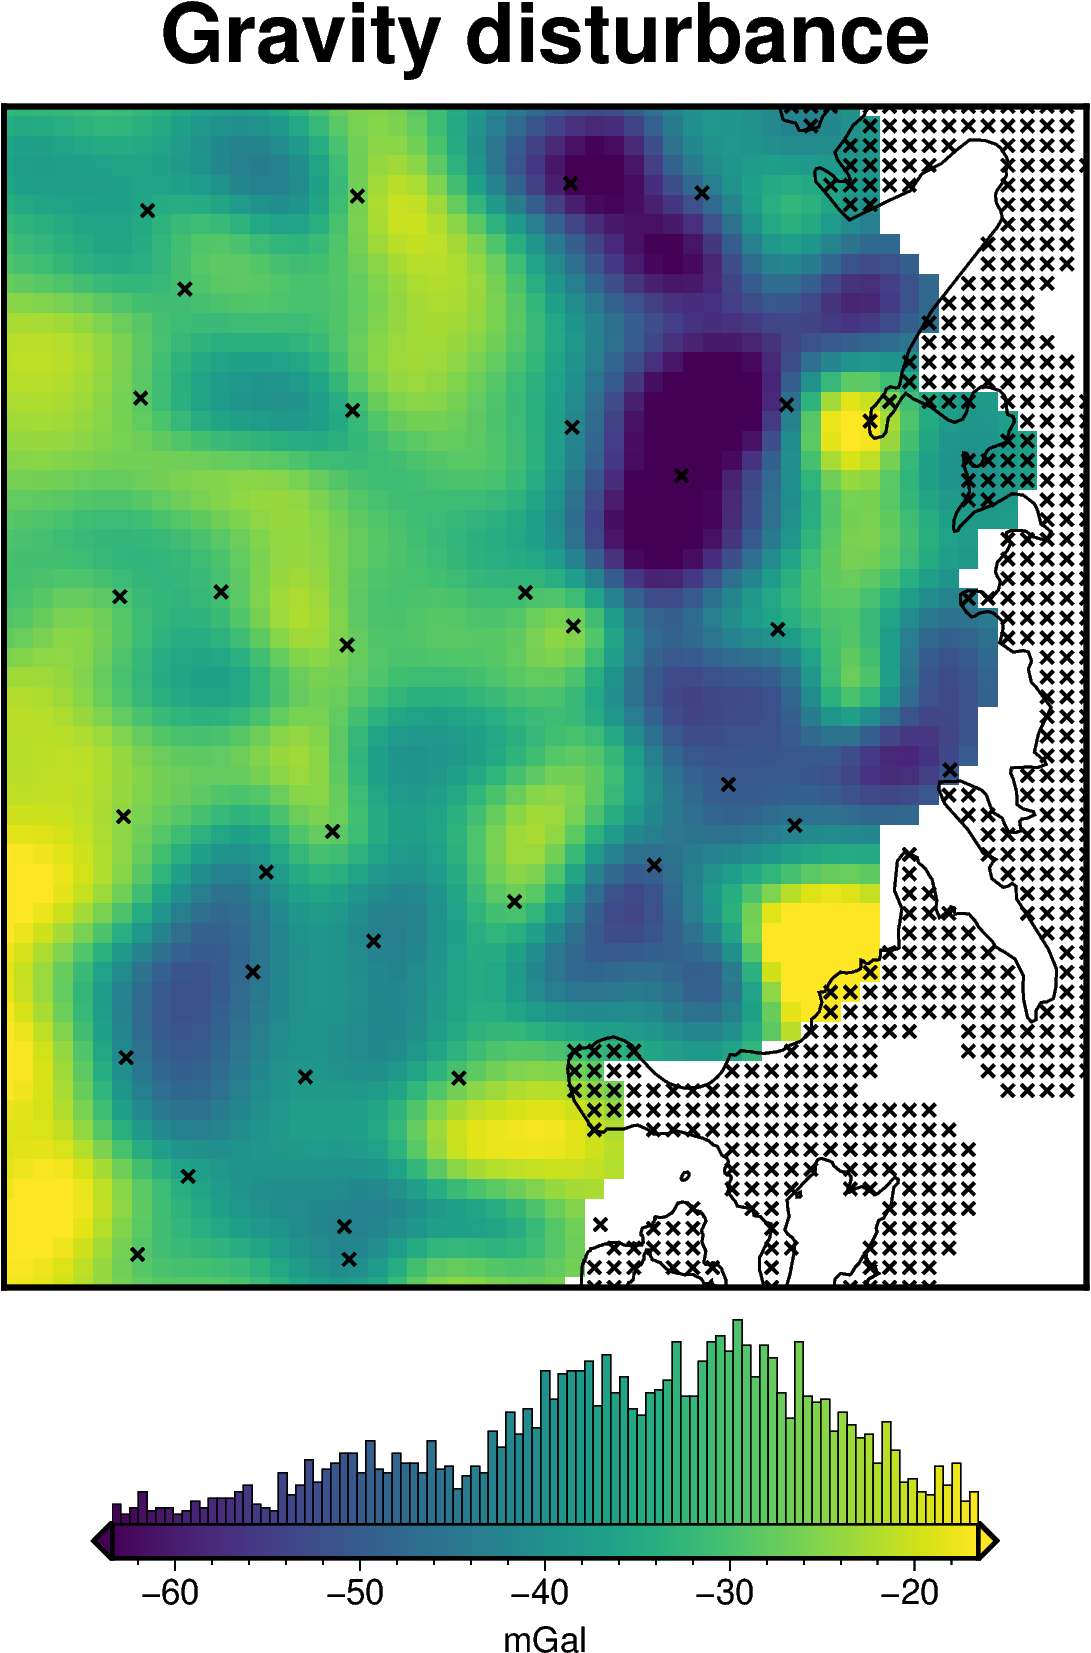

In [156]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()


fig = maps.plot_grd(
    grav_grid.Gobs,
    region=inversion_region,
    fig_height=10,
    title="Gravity disturbance",
    robust=True,
    hist=True,
    cbar_label="mGal",
    points=constraints[(constraints.inside) | (constraints.buffer)],
    points_style="x.15c",
    points_pen=".8p",
    coast=True,
    coast_version="measures-v2",

)
fig.show()

In [149]:
antgg = fetch.gravity(
    version="antgg-2021",
    region=inversion_region,
    spacing=grav_spacing,
    anomaly_type="DG"
).rename({"x": "easting", "y": "northing"})#.rename("Gobs").to_dataframe().reset_index()
antgg

INFO:root:returning grid with new region and/or registration, same spacing


<xarray.DataArray 'z' (northing: 61, easting: 56)> Size: 14kB
array([[ -19.39044  ,  -19.946957 ,  -19.140545 , ...,    8.164094 ,
         -21.558113 ,  -92.660995 ],
       [ -18.181835 ,  -17.805876 ,  -16.601532 , ...,   69.760284 ,
          24.140516 ,  -57.384117 ],
       [ -15.8521   ,  -14.578413 ,  -14.742216 , ...,   76.54604  ,
          30.258417 ,   -1.6863117],
       ...,
       [ -34.352337 ,  -35.50765  ,  -35.13931  , ..., -210.82832  ,
        -122.44772  ,  -59.84856  ],
       [ -35.381706 ,  -36.552944 ,  -37.92093  , ..., -215.93382  ,
        -191.95174  ,  -98.56006  ],
       [ -37.34017  ,  -38.499714 ,  -39.85254  , ..., -222.78896  ,
        -222.00345  , -157.65686  ]], dtype=float32)
Coordinates:
  * easting   (easting) float64 448B 1.3e+05 1.35e+05 1.4e+05 ... 4e+05 4.05e+05
  * northing  (northing) float64 488B -1.26e+06 -1.255e+06 ... -9.6e+05
Attributes:
    long_name:     z
    actual_range:  [-222.78895569  180.15449524]

In [103]:
# grav_grid["Gobs"] = grav_grid.Gobs.fillna(antgg)
# grav_grid.Gobs.plot(robust=True)
# grav_df = grav_grid.to_dataframe().reset_index()
# grav_df["upward"] = grav_df.upward.fillna(1e3)
# grav_df.describe()

In [150]:
# eqs_depth = 4.5 * np.mean(
#     vd.median_distance(
#         (coords[0],coords[1]),
#         k_nearest=1,
#     )
# )
# eqs_depth

In [22]:
# equivalent_source_parameter_dict = {
#     "depth": {
#         # "distribution": "uniform",
#         # "loc": 2*min_dist,  # lower bound
#         # "scale": 6*min_dist,  # range
#         "distribution": "normal",
#         "loc": eqs_depth,  # mean
#         "scale": eqs_depth/4,#20e3,  # standard deviation
#     },
#     "damping": {
#         # "distribution": "uniform",
#         # "loc": -40,  # lower bound base 10 exponent
#         # "scale": 40,  # range of exponent
#         "log": True,
#         "distribution": "normal",
#         "loc": np.log10(eqs.damping),  # mean
#         "scale": np.abs(np.log10(eqs.damping))/2,  # standard deviation
#     },
# }

# eqs_kwargs = dict(
#     block_size=grav_spacing,
#     damping=None,
#     depth="default",
# )

# regional_misfit_stats = uncertainty.equivalent_sources_uncertainty(
#     runs=10,
#     data=data,
#     coords=coords,
#     grid_points=grav_df,
#     parameter_dict=equivalent_source_parameter_dict,
#     plot_region=vd.pad_region(inversion_region, -grav_spacing),
#     # weight_by="score",
#     # weight_by="rmse",
#     **eqs_kwargs,
# )

In [23]:
# load gravity data
# grav_df = pd.read_csv(
#     "../../data/rosetta_eq_source_1k_levelled.csv.gz",
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# ).drop(columns=["inside"])

# grav_df = grav_df[~grav_df.test].drop(columns=["test"])
# grav_df = grav_df.dropna(subset=["Gobs"])
# grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
# grav_grid = grav_grid.coarsen(
#     easting=2, northing=2, boundary="trim"
# ).mean()
# grav_df = grav_grid.to_dataframe().reset_index()
# grav_grid.Gobs.plot()
# grav_df

In [151]:
# set densities
air_density = 1
ice_density = 915  # +/- 5, from Griggs and Bamber 2009/2011
water_density = 1024  # +/- 5, from Griggs and Bamber 2009/2011
sediment_density = 2300  # will likely change this

# ice prisms
density_contrast = ice_density - air_density
zref = 0
density_grid = xr.where(surface >= zref, density_contrast, -density_contrast)
ice_surface_prisms = utils.grids_to_prisms(
    surface,
    zref,
    density=density_grid,
)

# water prisms
density_contrast = water_density - ice_density
zref = 0
density_grid = xr.where(icebase >= zref, density_contrast, -density_contrast)
water_surface_prisms = utils.grids_to_prisms(
    icebase,
    zref,
    density=density_grid,
)

# sediment prisms
density_contrast = sediment_density - water_density
zref = 0
density_grid = xr.where(starting_bed >= zref, density_contrast, -density_contrast)
starting_bed_prisms = utils.grids_to_prisms(
    starting_bed,
    zref,
    density=density_grid,
)

In [152]:
# calculate forward gravity of prisms
grav_df["ice_surface_grav"] = ice_surface_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["water_surface_grav"] = water_surface_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["starting_gravity"] = starting_bed_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df.describe()

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

northing        easting  upward         Gobs  ice_surface_grav  \
count  2.704000e+03    2704.000000  2704.0  2704.000000       2704.000000   
mean  -1.099945e+06  241294.378698  1000.0   -35.588608         -0.212549   
std    8.304406e+04   68359.346468     0.0    11.465488          1.510888   
min   -1.260000e+06  130000.000000  1000.0   -75.078904         -1.600429   
25%   -1.165000e+06  185000.000000  1000.0   -41.720980         -0.534451   
50%   -1.095000e+06  240000.000000  1000.0   -33.978558         -0.434925   
75%   -1.030000e+06  295000.000000  1000.0   -27.799534         -0.255482   
max   -9.600000e+05  390000.000000  1000.0     2.948951         28.071864   

       water_surface_grav  starting_gravity  
count         2704.000000       2704.000000  
mean            -1.692505        -40.510683  
std              0.379791         11.497653  
min             -2.998431        -73.240868  
25%             -1.839920        -46.055888  
50%             -1.659774        -39.462616  
75%             -1.570237        -33.473471  
max              3.118785         36.188225

In [153]:
grav_df["gravity_anomaly"] = (
    grav_df.Gobs - grav_df.ice_surface_grav - grav_df.water_surface_grav
)

In [158]:
# get gravity points within RIS
grav_gdf = gpd.GeoDataFrame(
    grav_df,
    geometry=gpd.points_from_xy(x=grav_df.easting, y=grav_df.northing),
    crs="EPSG:3031",
)
grav_df["inside"] = grav_gdf.within(RIS_outline.geometry[0])
grav_df["mask"] = np.where(grav_df.inside, 1, 0)
grav_df

northing   easting  upward       Gobs  ice_surface_grav  \
0    -1260000.0  130000.0  1000.0 -17.341547         -0.766811   
1    -1260000.0  135000.0  1000.0 -17.709587         -0.729187   
2    -1260000.0  140000.0  1000.0 -18.463805         -0.707232   
3    -1260000.0  145000.0  1000.0 -19.801125         -0.677641   
4    -1260000.0  150000.0  1000.0 -21.739552         -0.668077   
...         ...       ...     ...        ...               ...   
3399  -960000.0  325000.0  1000.0 -41.153816         -0.087816   
3400  -960000.0  330000.0  1000.0 -42.079220          4.834539   
3401  -960000.0  335000.0  1000.0 -42.056946         13.179008   
3402  -960000.0  340000.0  1000.0 -41.090088          3.679461   
3403  -960000.0  345000.0  1000.0 -39.575359          2.957714   

      water_surface_grav  starting_gravity  gravity_anomaly  inside  mask  
0              -1.466447        -43.440162       -15.108288    True     1  
1              -1.503063        -43.702671       -15.477337    True     1  
2              -1.525884        -43.938276       -16.230688    True     1  
3              -1.553996        -44.148243       -17.569488    True     1  
4              -1.563530        -44.339179       -19.507945    True     1  
...                  ...               ...              ...     ...   ...  
3399           -1.195712        -19.780000       -39.870289    True     1  
3400           -0.619601         -9.138426       -46.294159   False     0  
3401           -0.155896         -2.860038       -55.080058   False     0  
3402           -2.041706        -24.746982       -42.727842   False     0  
3403           -2.646863        -31.499154       -39.886209    True     1  

[2704 rows x 10 columns]

In [186]:
# use the constraints to find the best regional field
regional_grav_kwargs = dict(
    method="constraints",
    constraints_df=constraints,

    # constraints_weights_column="weights",
    # grid_method="eq_sources",
    # cv=True,
    # cv_kwargs=dict(
    #     n_trials=200,
    #     damping_limits=(1e-20, 1),
    #     depth_limits=(100, 100e3),
    #     progressbar=True,
    #     fname="tmp_regional_sep",
    # ),
    # damping=None,
    # depth="default",
    # block_size=grav_spacing*2,
    # mask_column="mask",
    grid_method="pygmt",
    tension_factor=.35,
    # # grid_method="verde",
    # # spline_dampings=[None, 1e-10, 1e-5, 1e-1, 10],
    # method="eq_sources",
    # depth=100e3,
    # damping=None,
    # block_size=grav_spacing * 10,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)
grav_df.describe()

northing        easting  upward         Gobs  ice_surface_grav  \
count  2.704000e+03    2704.000000  2704.0  2704.000000       2704.000000   
mean  -1.099945e+06  241294.378698  1000.0   -35.588608         -0.212549   
std    8.304406e+04   68359.346468     0.0    11.465488          1.510888   
min   -1.260000e+06  130000.000000  1000.0   -75.078904         -1.600429   
25%   -1.165000e+06  185000.000000  1000.0   -41.720980         -0.534451   
50%   -1.095000e+06  240000.000000  1000.0   -33.978558         -0.434925   
75%   -1.030000e+06  295000.000000  1000.0   -27.799534         -0.255482   
max   -9.600000e+05  390000.000000  1000.0     2.948951         28.071864   

       water_surface_grav  starting_gravity  gravity_anomaly         mask  \
count         2704.000000       2704.000000      2704.000000  2704.000000   
mean            -1.692505        -40.510683       -33.683555     0.981139   
std              0.379791         11.497653        11.591725     0.136059   
min             -2.998431        -73.240868       -73.002409     0.000000   
25%             -1.839920        -46.055888       -39.970113     1.000000   
50%             -1.659774        -39.462616       -32.017758     1.000000   
75%             -1.570237        -33.473471       -25.761245     1.000000   
max              3.118785         36.188225         4.764508     1.000000   

            misfit          res          reg  
count  2704.000000  2704.000000  2704.000000  
mean      6.827129     1.884652     4.942476  
std      13.338905     7.175752    12.609526  
min    -104.165375   -21.313765  -104.165375  
25%       0.984519    -2.324859     2.291233  
50%       7.530898     0.802787     6.567679  
75%      13.770714     5.439383    11.927875  
max      56.788185    37.223501    33.662785

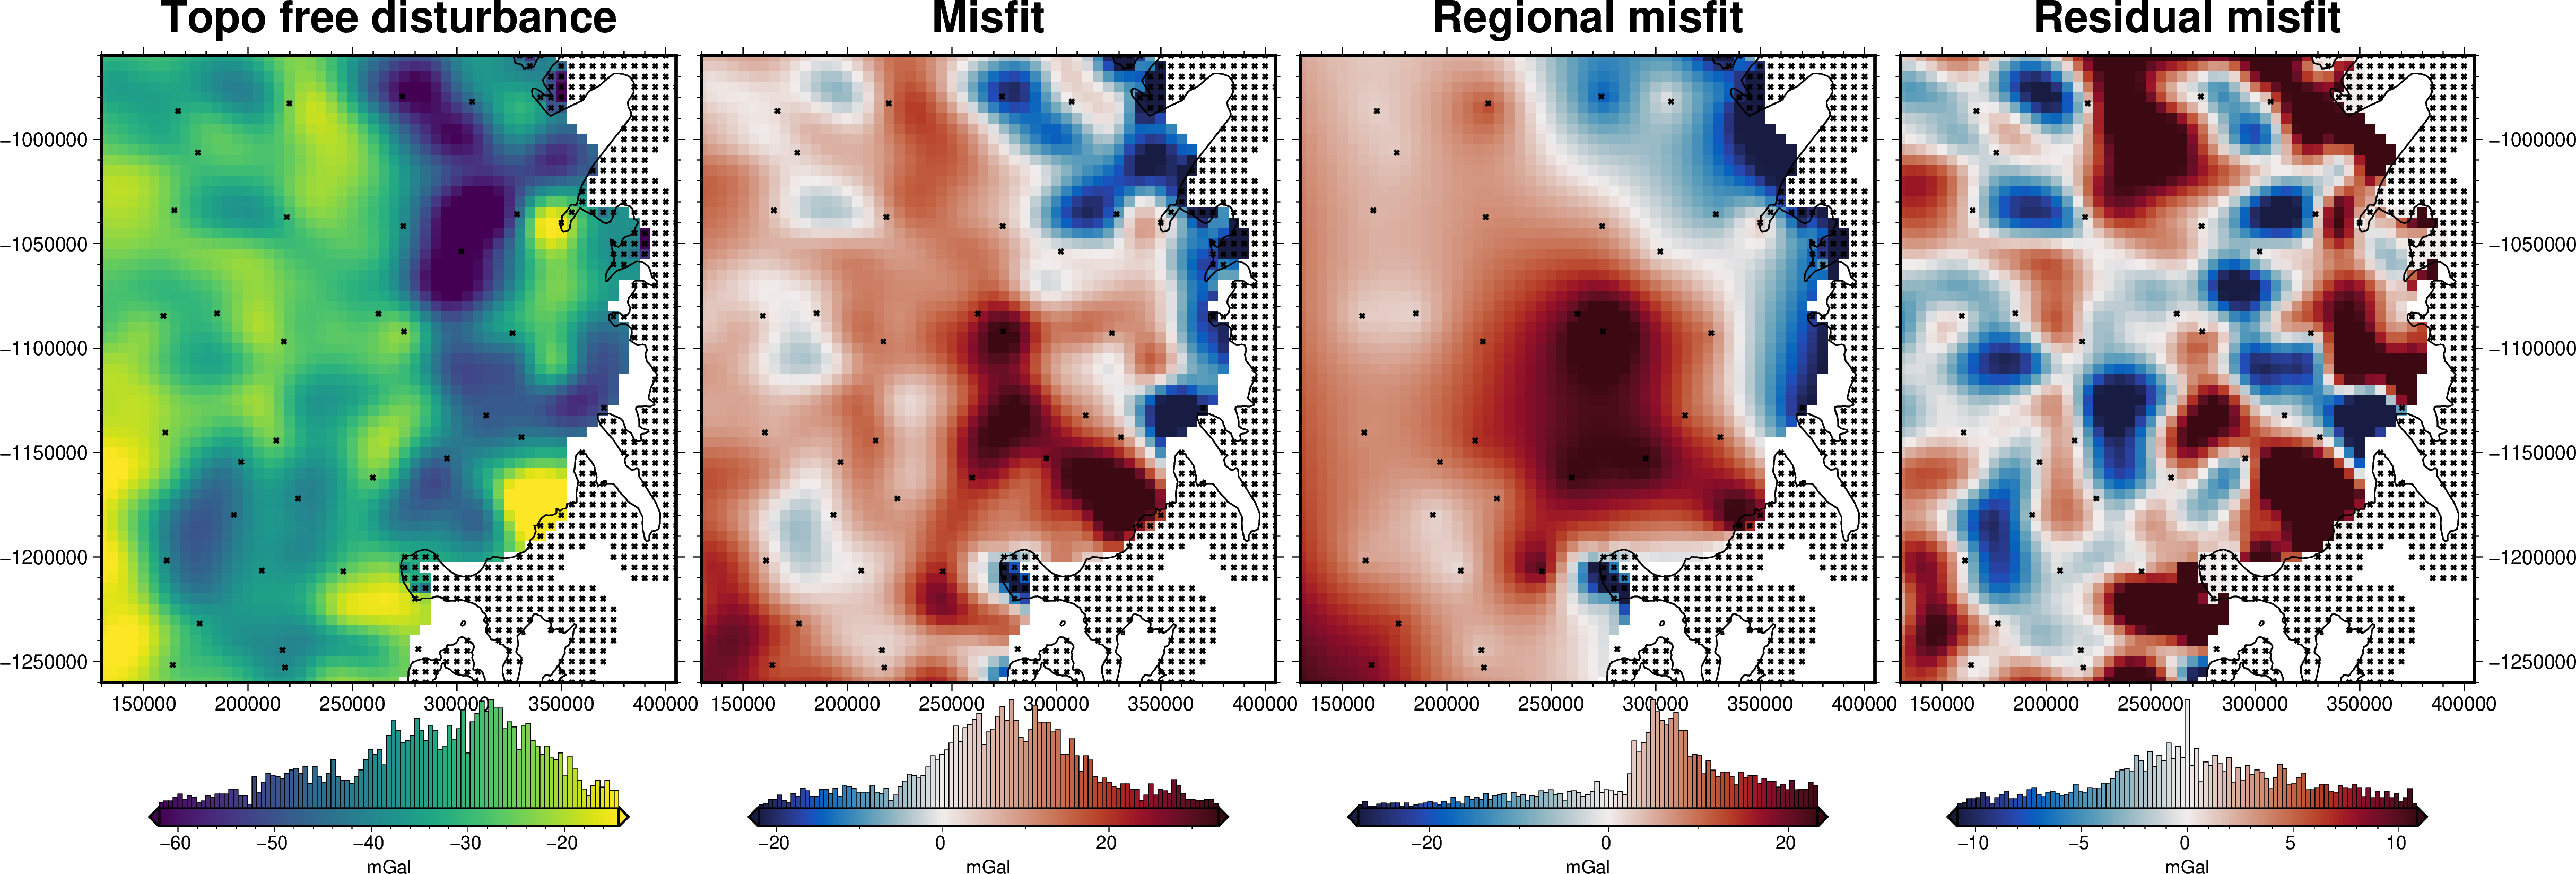

In [187]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    robust=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=constraints[(constraints.inside) | (constraints.buffer)],
    points_style="x.1c",
    points_pen="1p",
    coast=True,
    coast_version="measures-v2",
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    robust=True,
    cbar_label="mGal",
    frame=["nSwe", "xaf10000", "yaf10000"],
    points=constraints[(constraints.inside) | (constraints.buffer)],
    points_style="x.1c",
    points_pen="1p",
    coast=True,
    coast_version="measures-v2",
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    robust=True,
    cbar_label="mGal",
    frame=["nSwe", "xaf10000", "yaf10000"],
    points=constraints[(constraints.inside) | (constraints.buffer)],
    points_style="x.1c",
    points_pen="1p",
    coast=True,
    coast_version="measures-v2",
)

# maxabs = vd.maxabs(polar_utils.get_min_max(grav_grid.res, robust=True))
maxabs = min(np.abs(polar_utils.get_min_max(grav_grid.res, robust=True)))
cpt_lims = [-maxabs, maxabs]
fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=cpt_lims,
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraints[(constraints.inside) | (constraints.buffer)],
    points_style="x.1c",
    points_pen="1p",
    coast=True,
    coast_version="measures-v2",
)
fig.show()

# Constraints grid


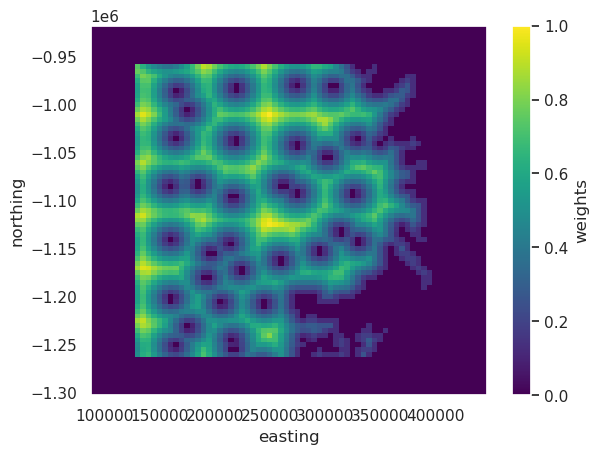

In [190]:
min_dist = utils.normalized_mindist(
    constraints,
    starting_bed_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    region=inversion_region,
)
starting_bed_prisms["weights"] = min_dist
starting_bed_prisms.weights.plot()

# Inversion

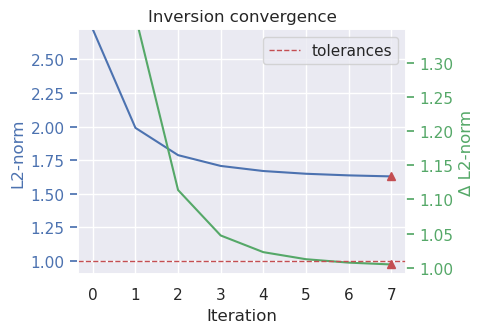

In [227]:
logging.getLogger().setLevel(logging.WARN)

# set kwargs for inversion
kwargs = dict(
    max_iterations=200,
    l2_norm_tolerance=1,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesn't decrease by at least 1%
    upper_confining_layer=icebase,
)

# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion(
    grav_df=grav_df,
    solver_damping=0.01,
    results_fname="../../results/RIS_inversion",
    prism_layer=starting_bed_prisms,
    plot_dynamic_convergence=True,
    apply_weighting_grid=True,
    weighting_grid=starting_bed_prisms.weights,
    **kwargs,
)

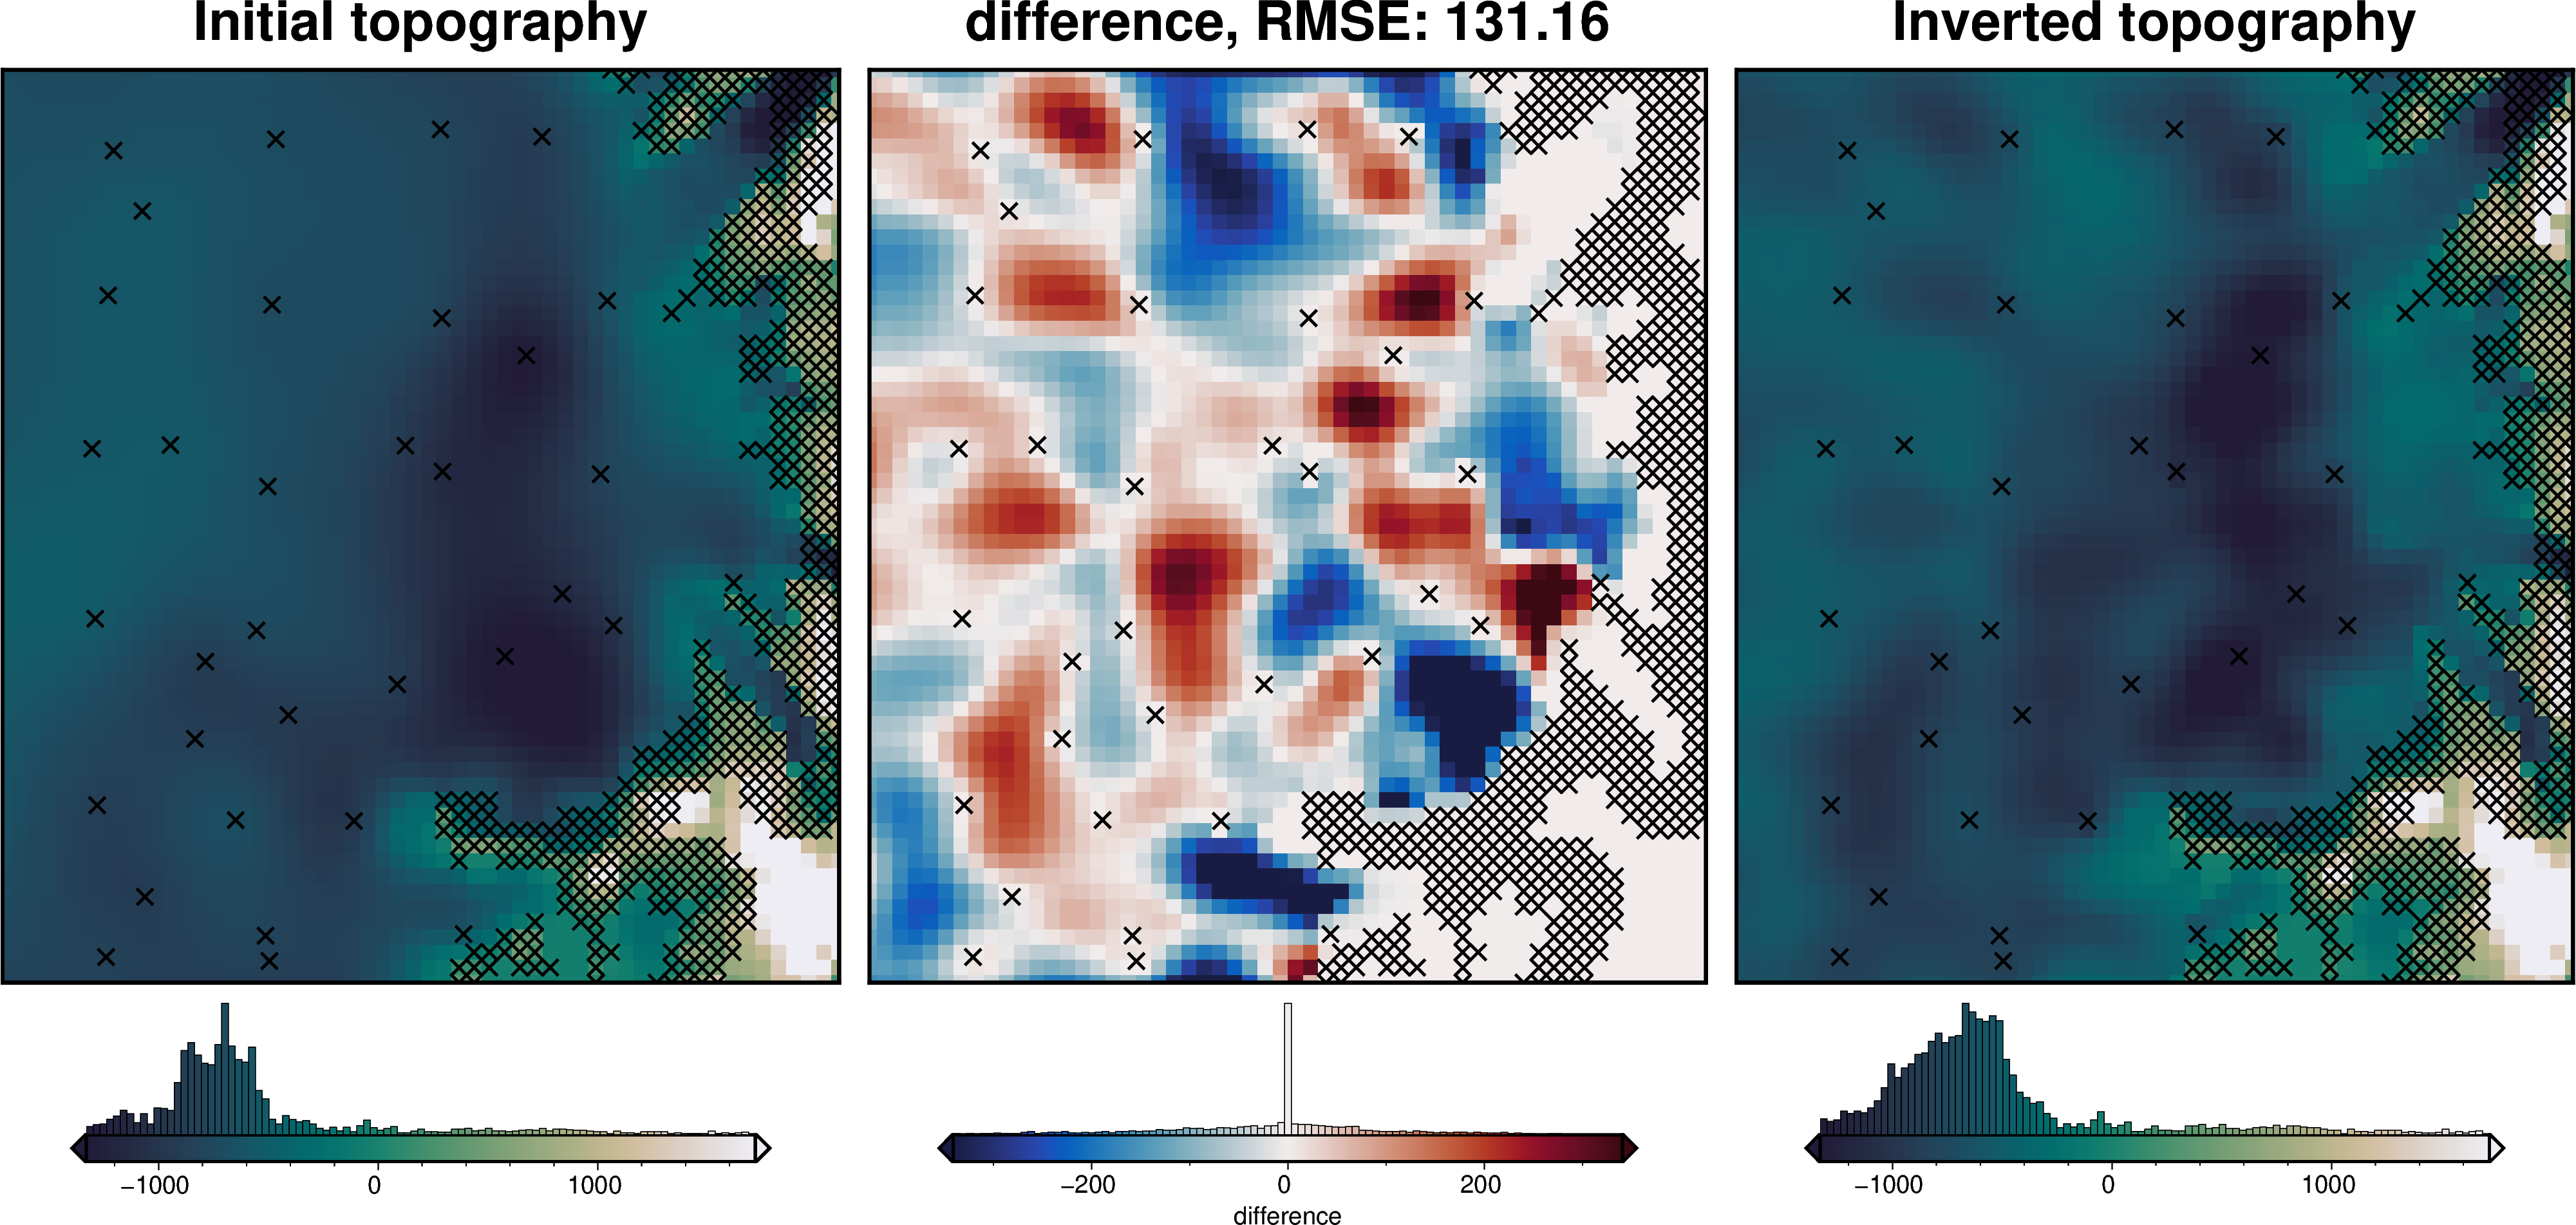

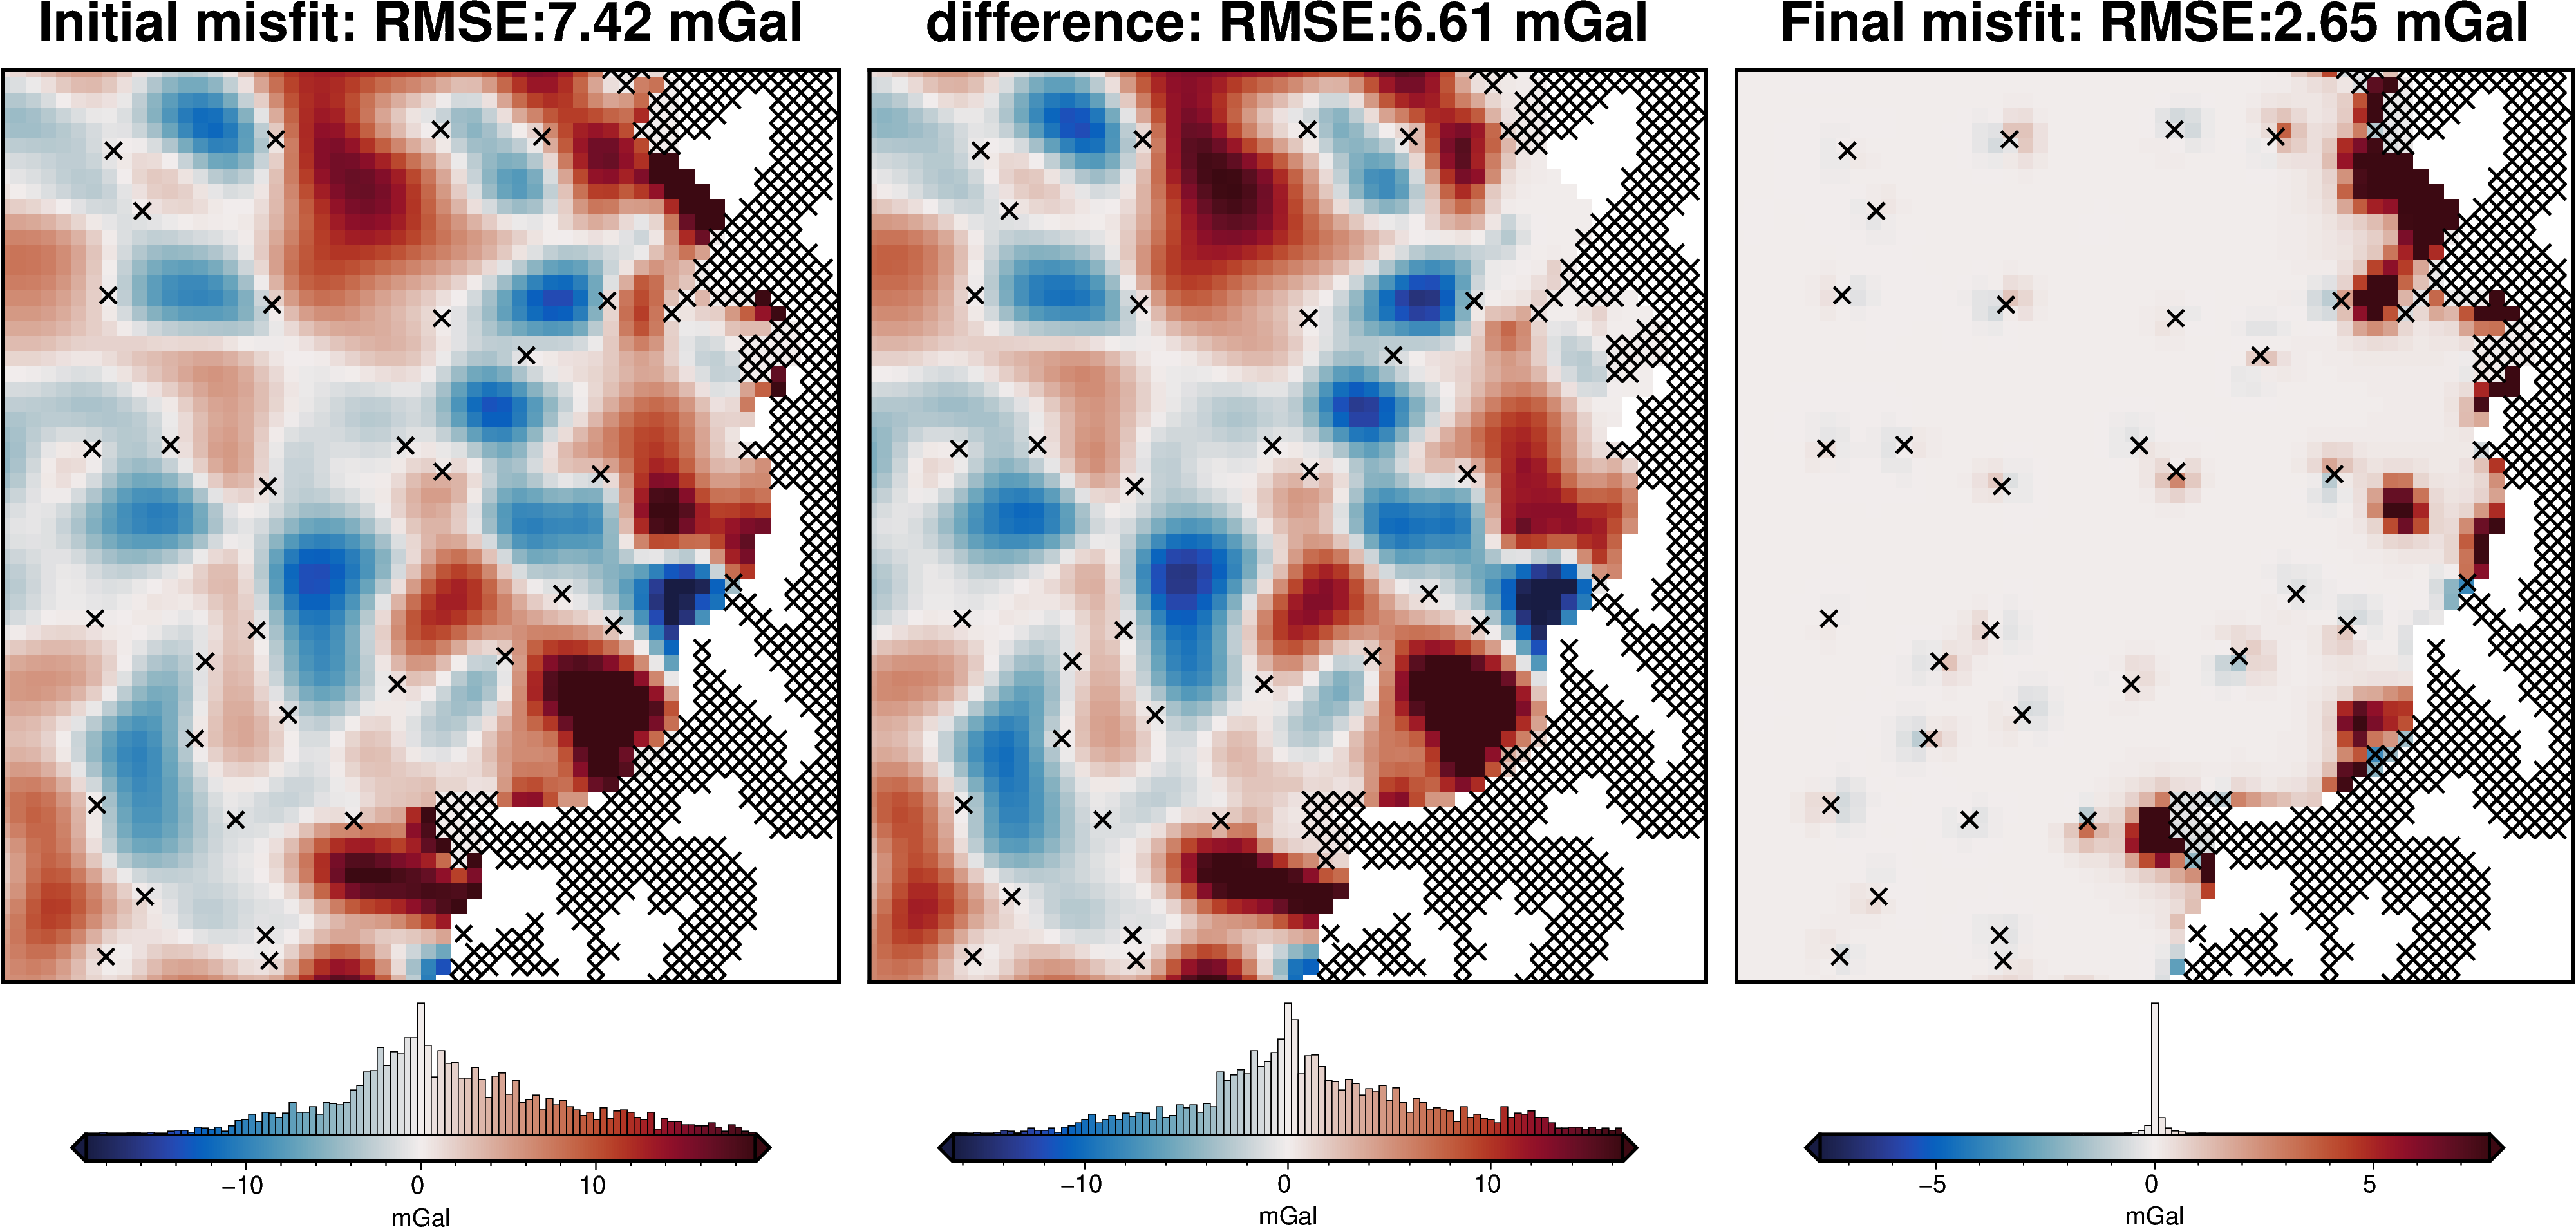

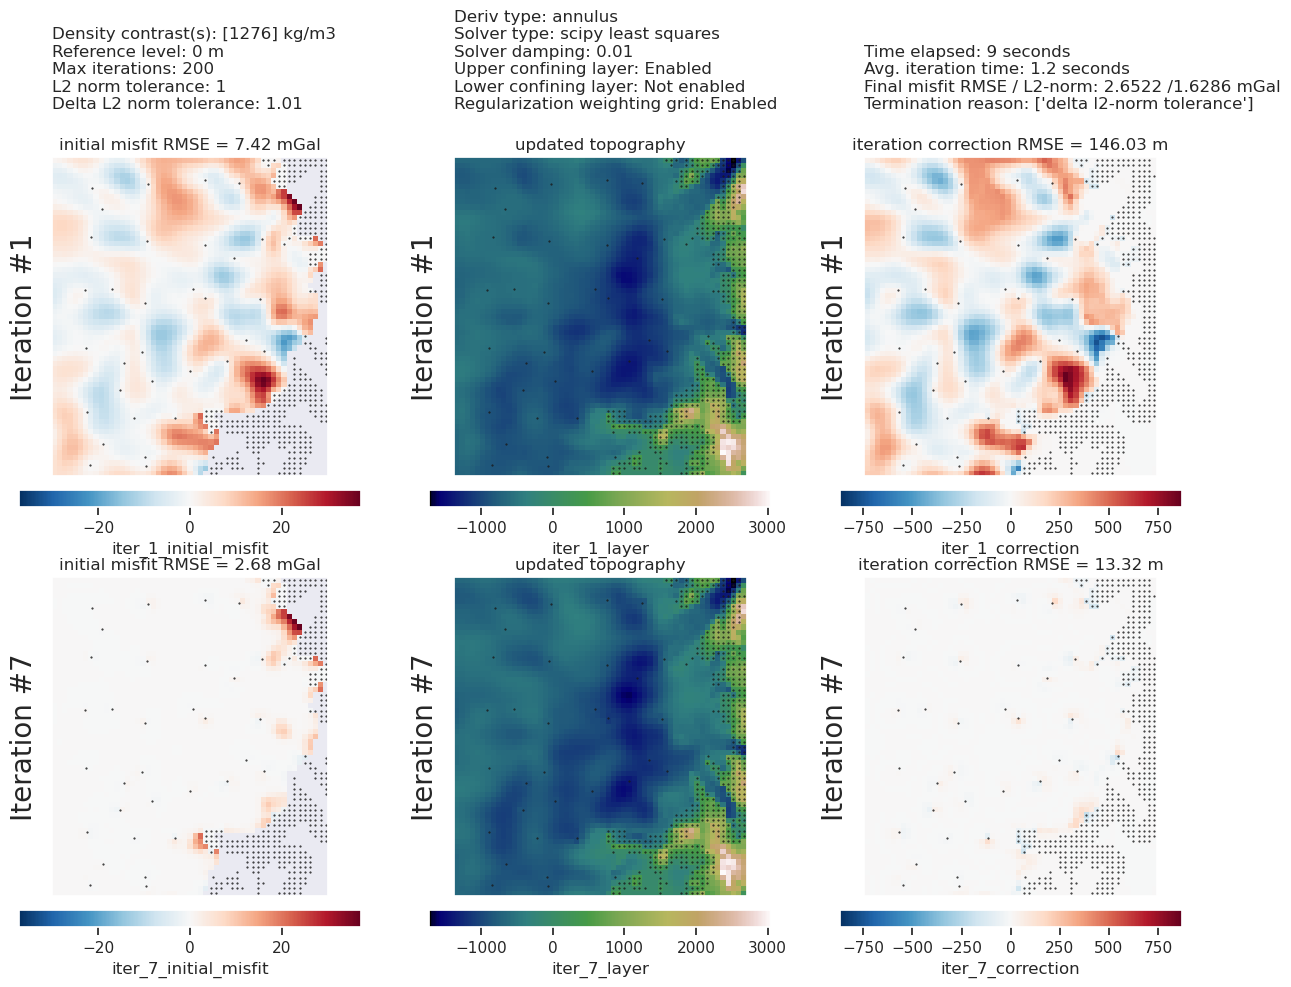

In [200]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints_df=constraints[(constraints.inside) | (constraints.buffer)],
)

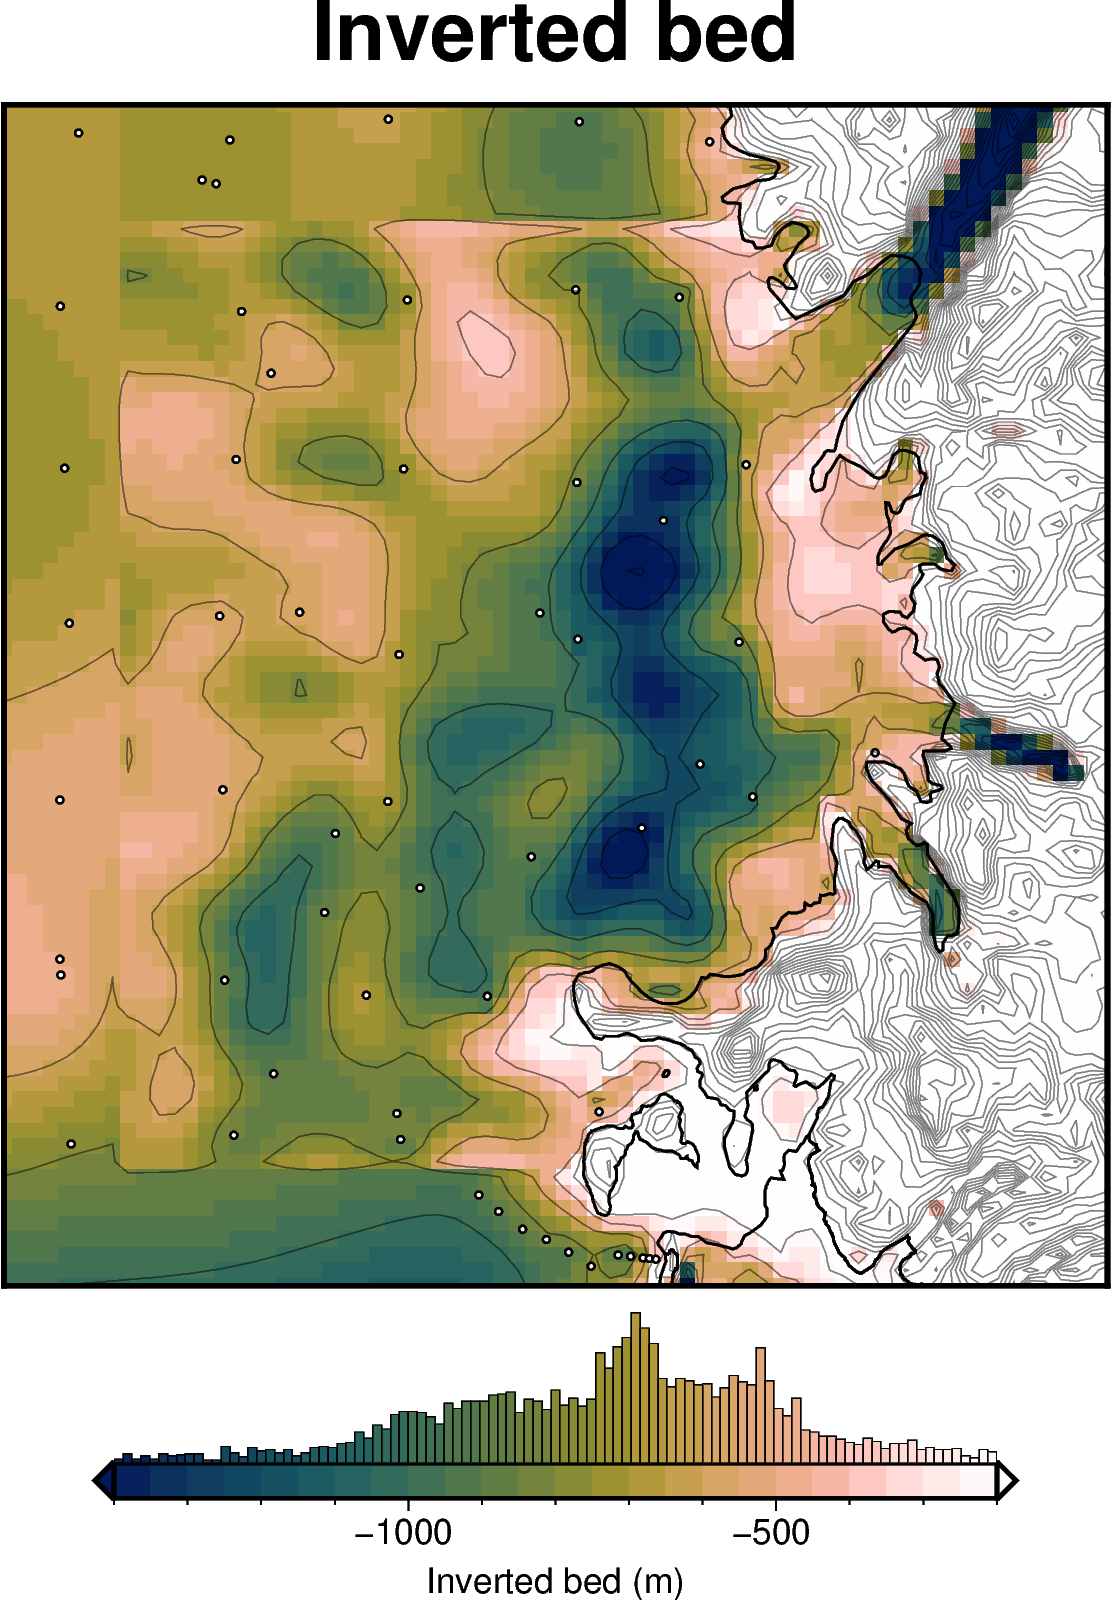

In [201]:
ds = inversion_results[0].set_index(["northing", "easting"]).to_xarray()
cols = [s for s in inversion_results[0].columns.to_list() if "_layer" in s]
final_bed = ds[cols[-1]]

lims = [-1400, -200]
pygmt.grd2cpt(
    grid=final_bed,
    cmap="batlowW",
    # reverse=True,
    limit=lims,
    nlevels=25,  # background=True,
    output="../../plotting/tmp.cpt",
)

fig = maps.plot_grd(
    final_bed,
    fig_height=10,
    coast=True,
    coast_version="measures-v2",
    region=buffer_region,
    # cmap="rain",
    cmap="../../plotting/tmp.cpt",
    # reverse_cpt=True,
    title="Inverted bed",
    cpt_lims=lims,
    cbar_label="Inverted bed (m)",
    hist=True,
    cbar_yoffset=1.5,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
fig.grdcontour(
    grid=final_bed,
    interval=200,
    annotation=None,
    transparency=50,
)

fig.show()

# Damping Cross-Validation

INFO:invert4geom:saving all results with root name '../../results/RIS_damping_cv'
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
ERROR:invert4geom:Cannot convert non-finite values (NA or inf) to integer
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
INFO:invert4geom:running damping cross validation


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 8
INFO:invert4geom:	parameter: {'damping': 0.0038776934319452003}
INFO:invert4geom:	scores: [2.760790869233043]
INFO:invert4geom:results saved to ../../results/RIS_damping_cv_results.pickle.pickle


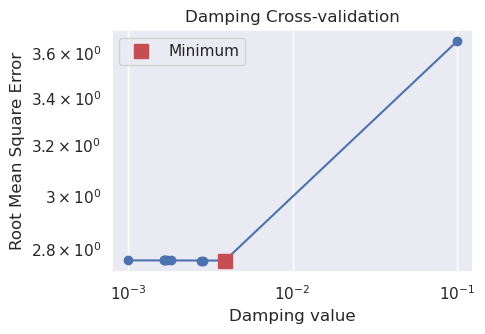

In [ ]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_bed_prisms,
    # for creating test/train splits
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=10,
    plot_cv=True,
    fname="../../results/RIS_damping_cv",
    apply_weighting_grid=True,
    weighting_grid=starting_bed_prisms.weights,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [213]:
# load saved inversion results
with pathlib.Path("../../results/RIS_damping_cv_results.pickle").open("rb") as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/RIS_damping_cv_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [214]:
best_damping = parameters.get("Solver damping")
best_damping

0.0038776934319452003

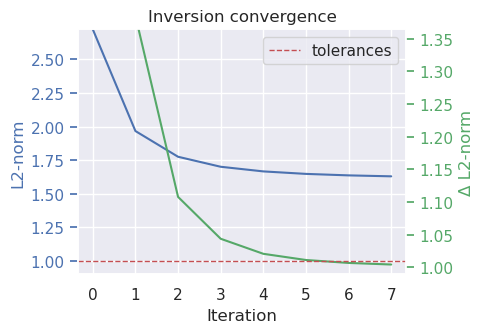

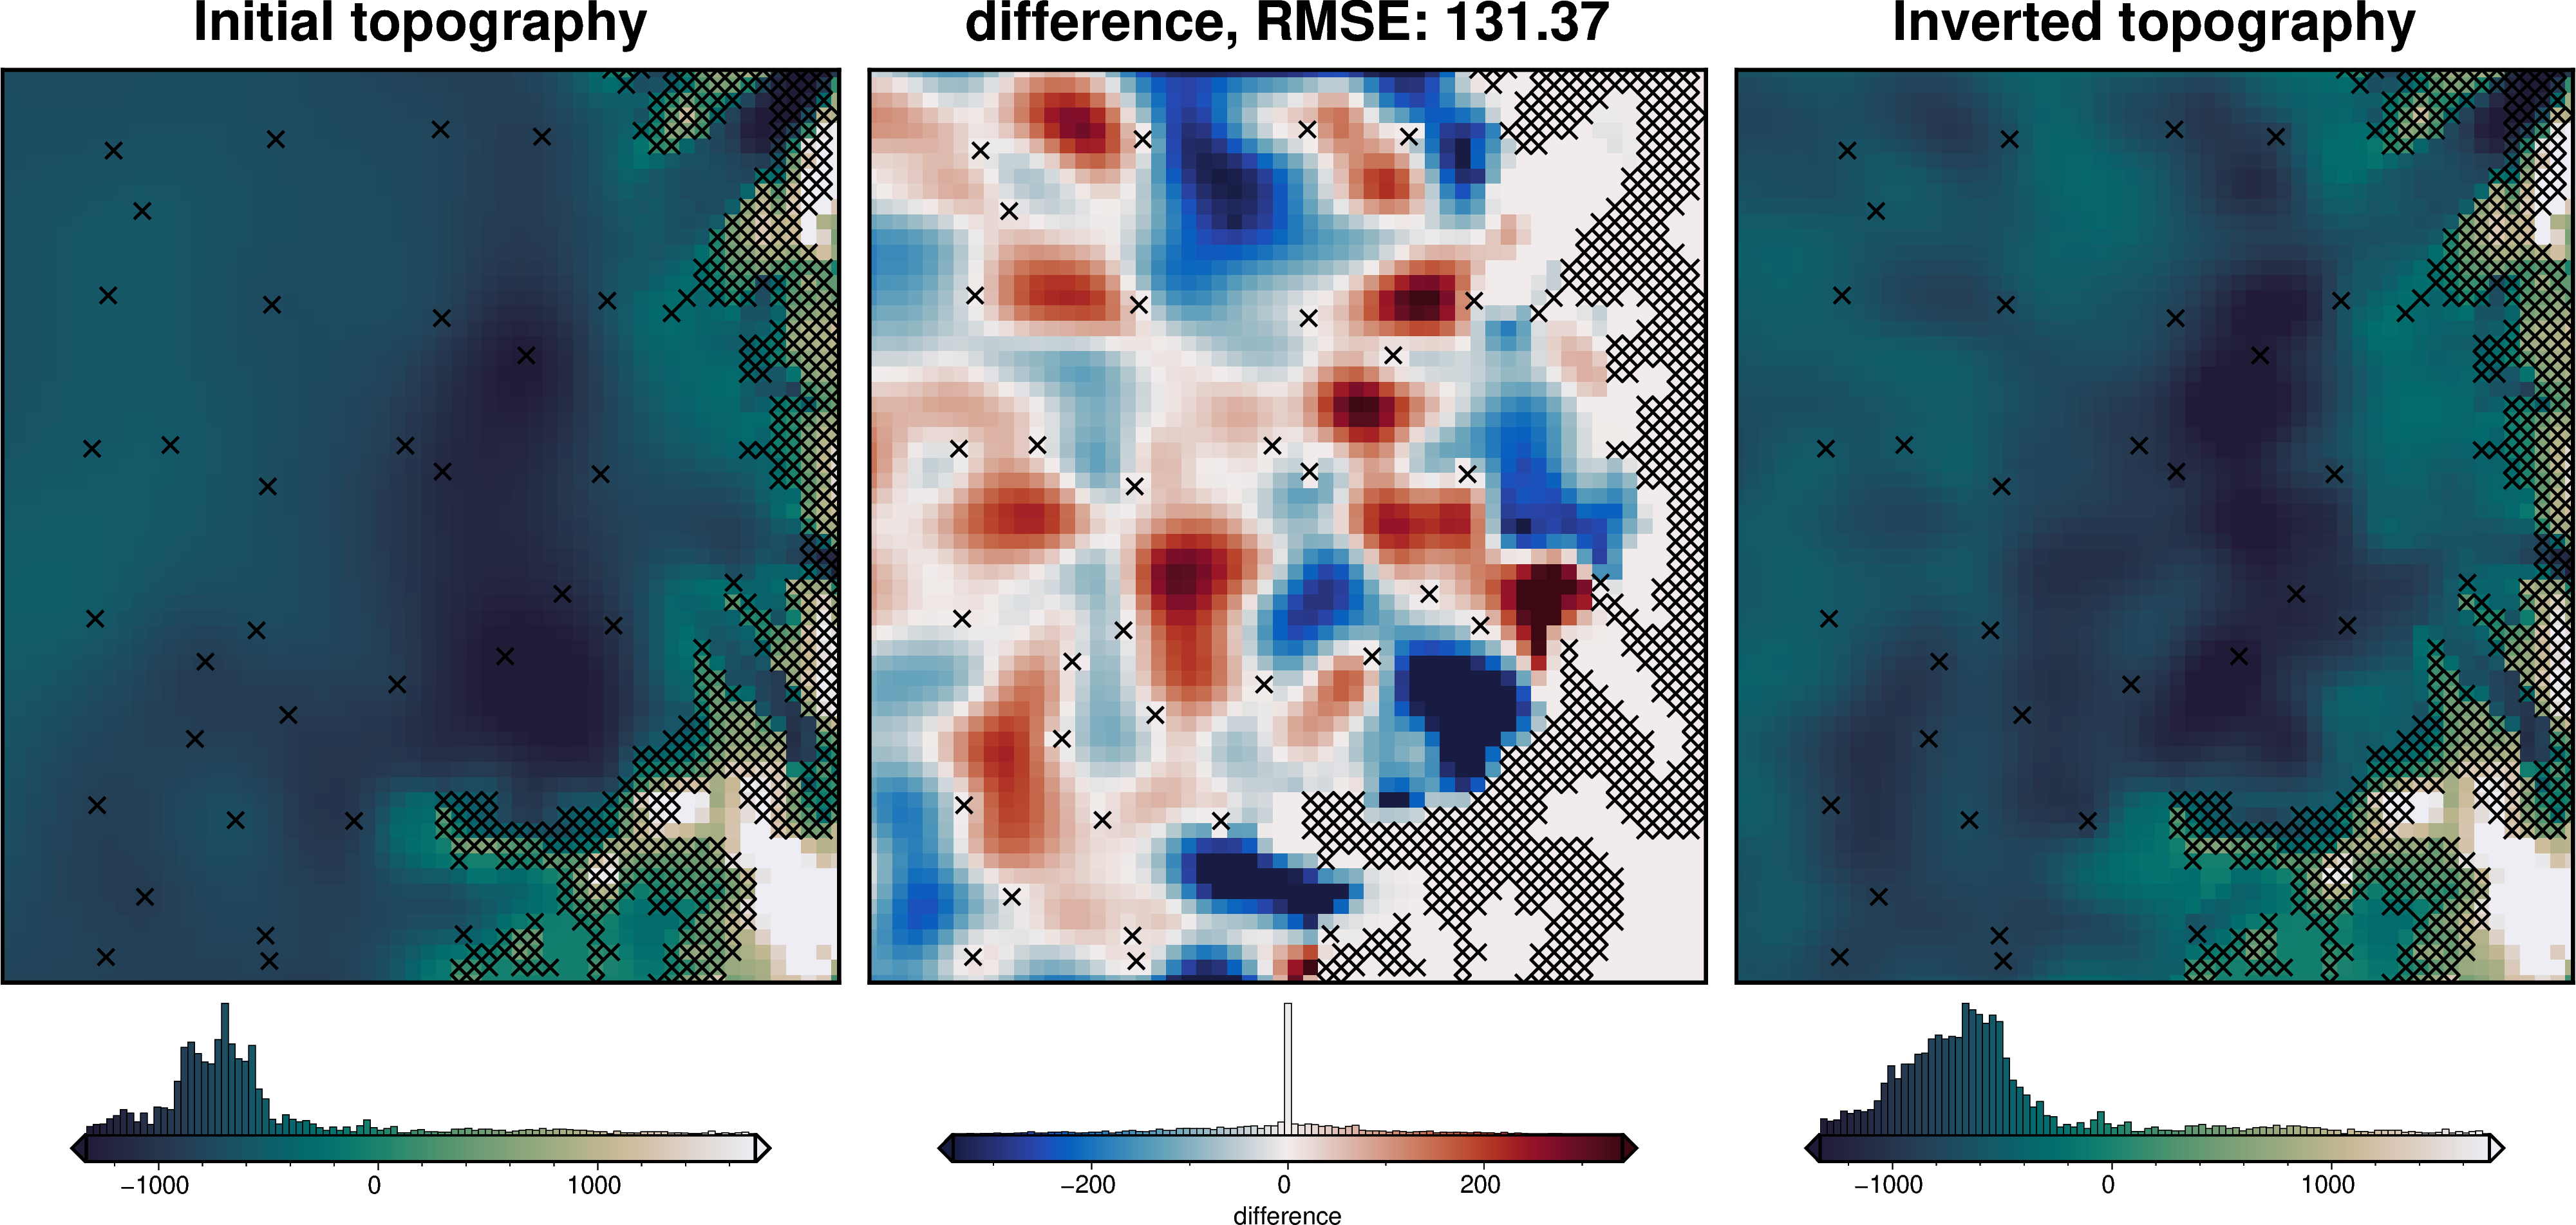

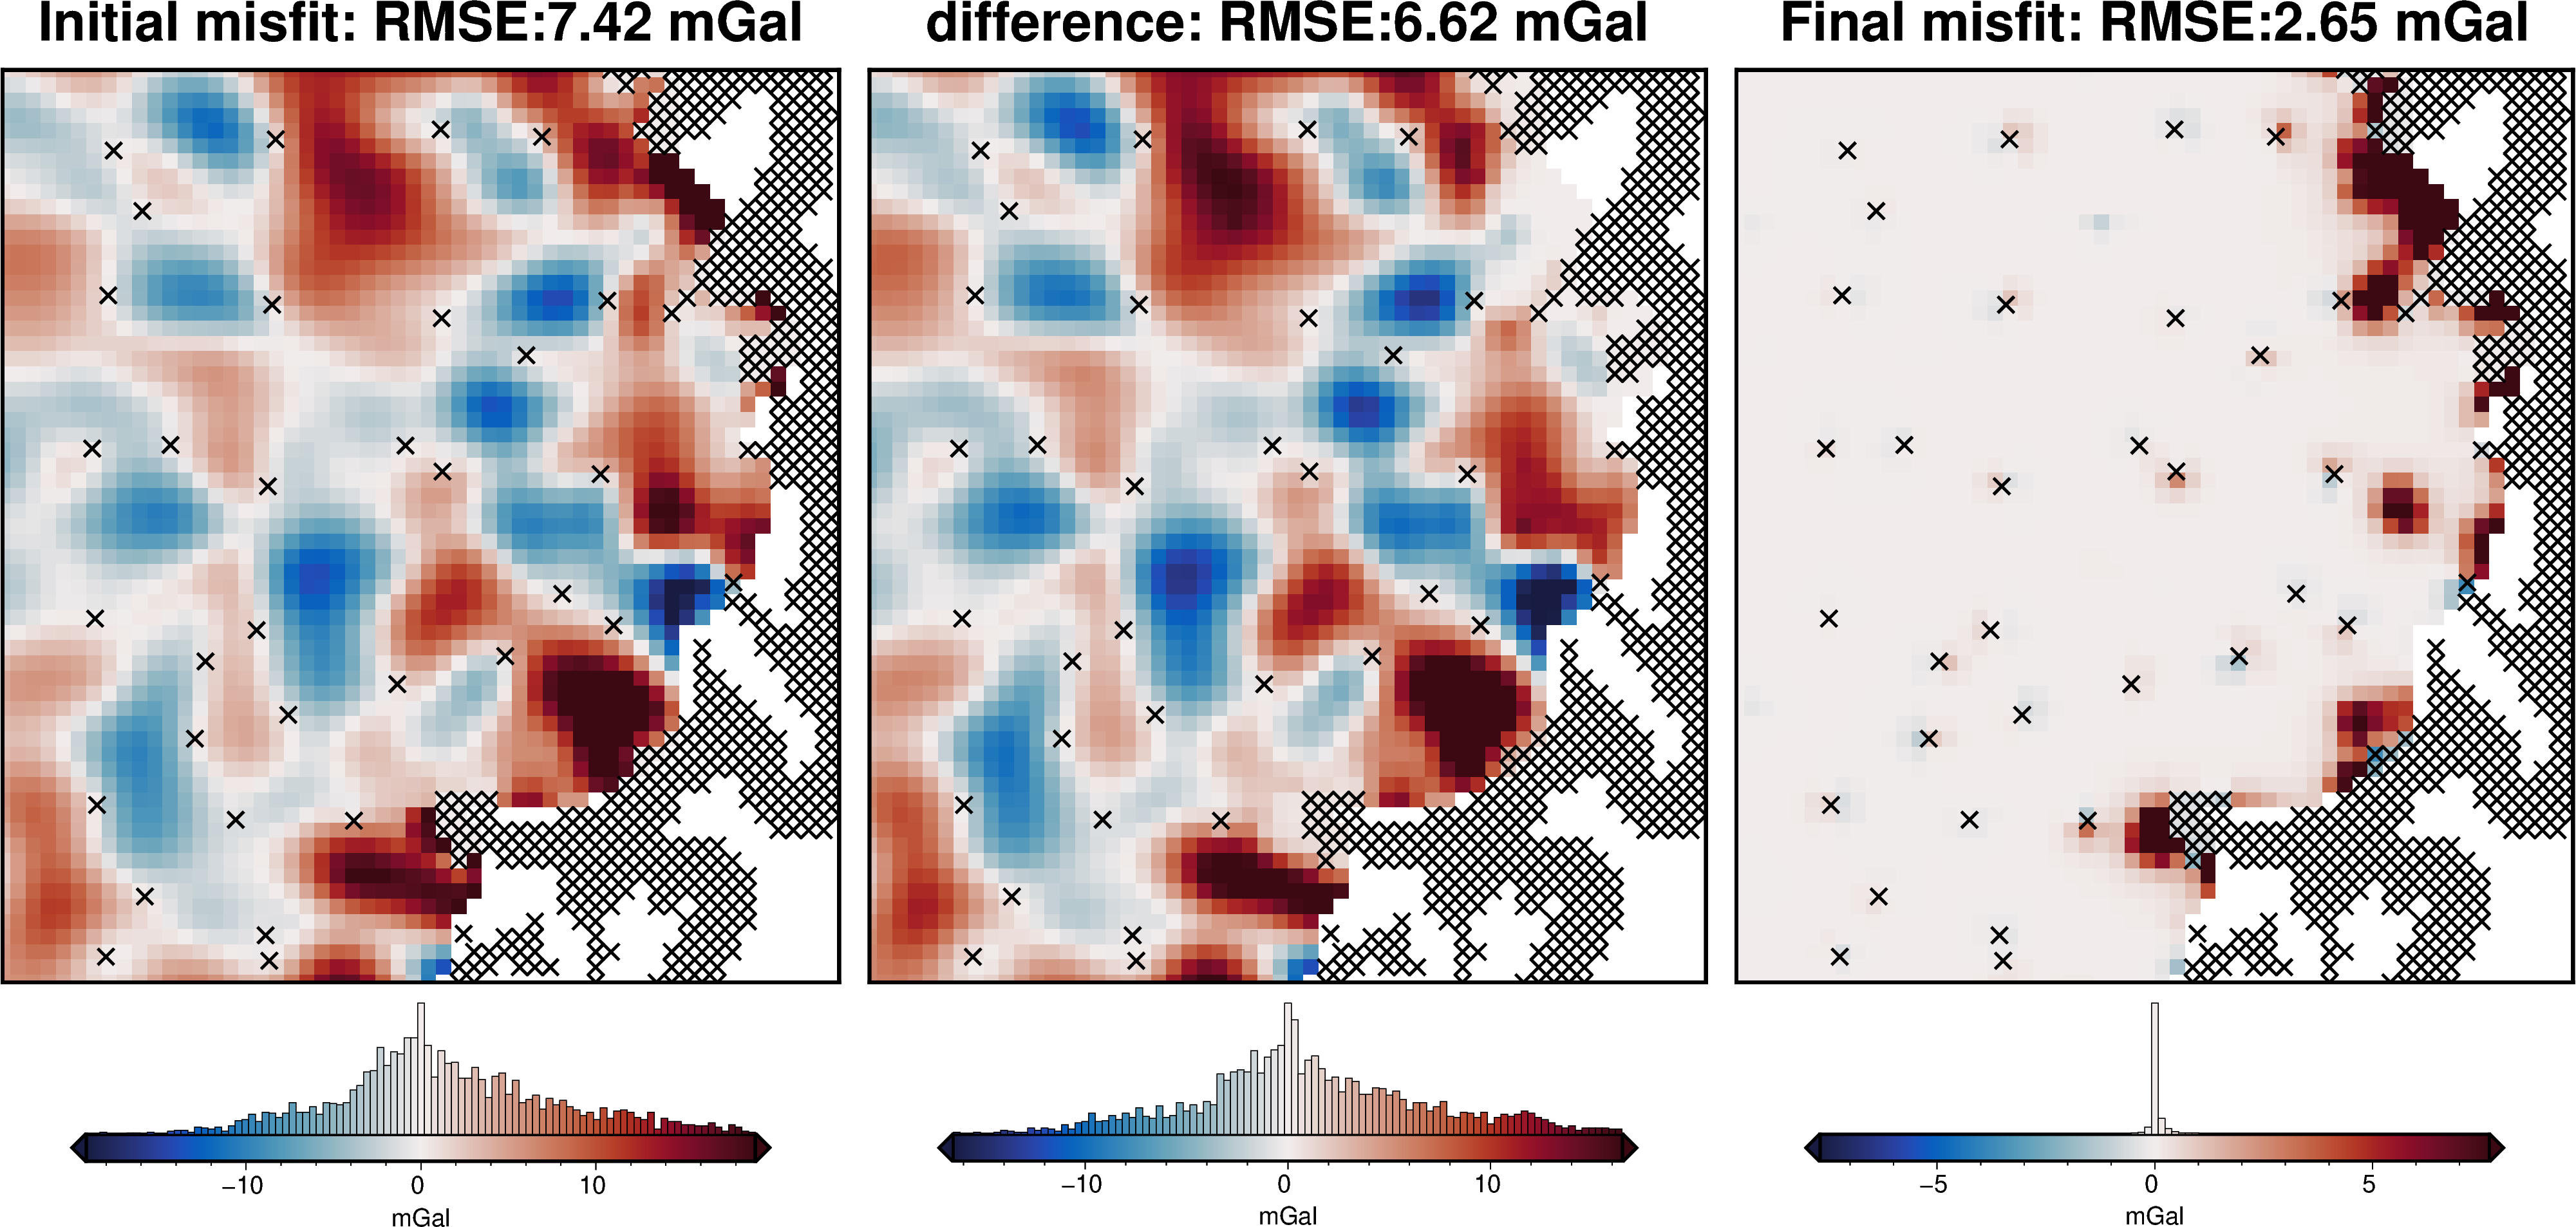

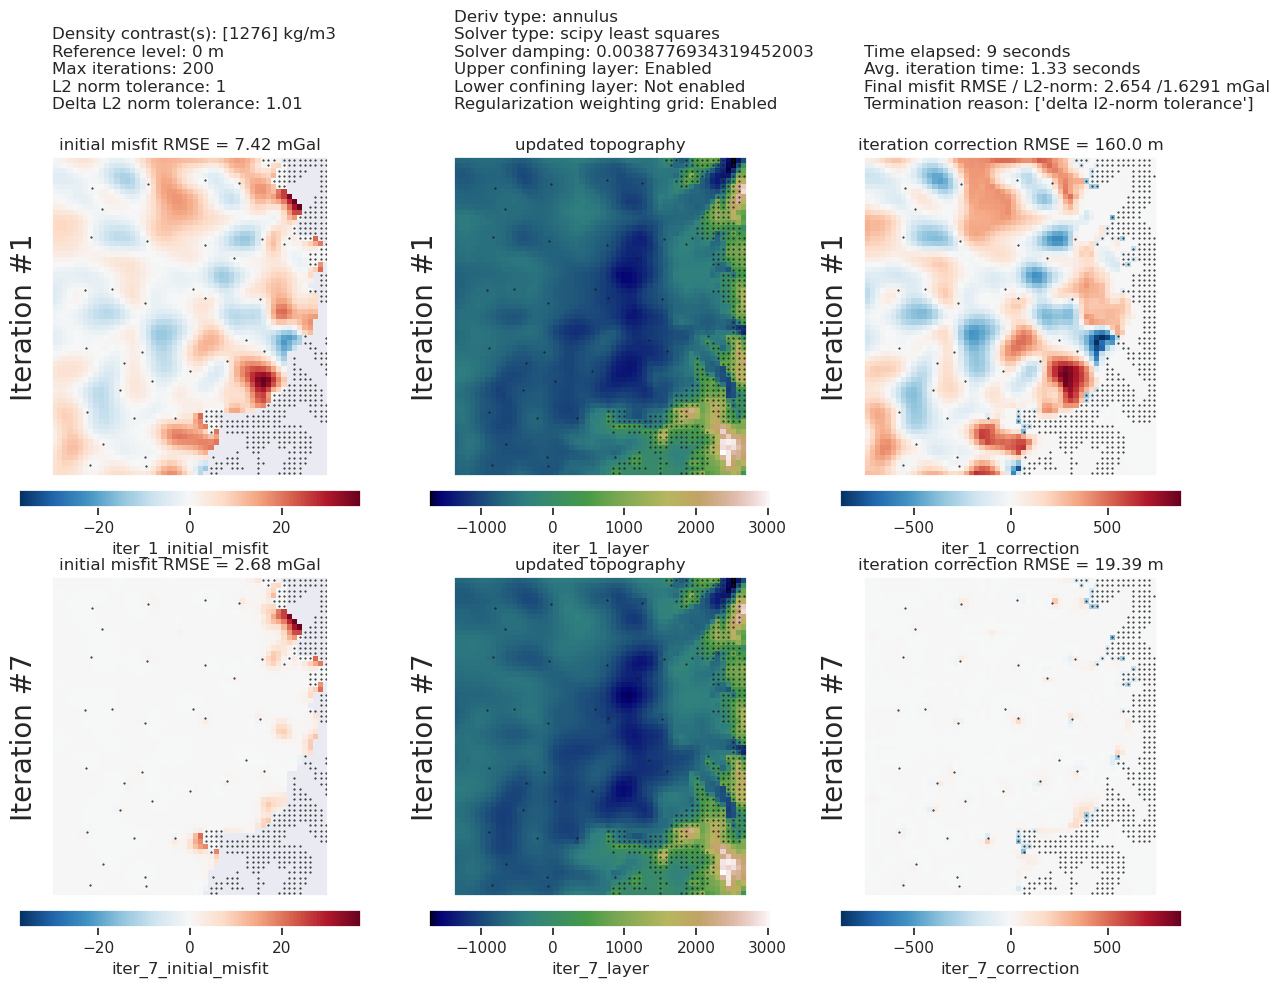

In [216]:
plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    constraints_df=constraints[(constraints.inside) | (constraints.buffer)],
)

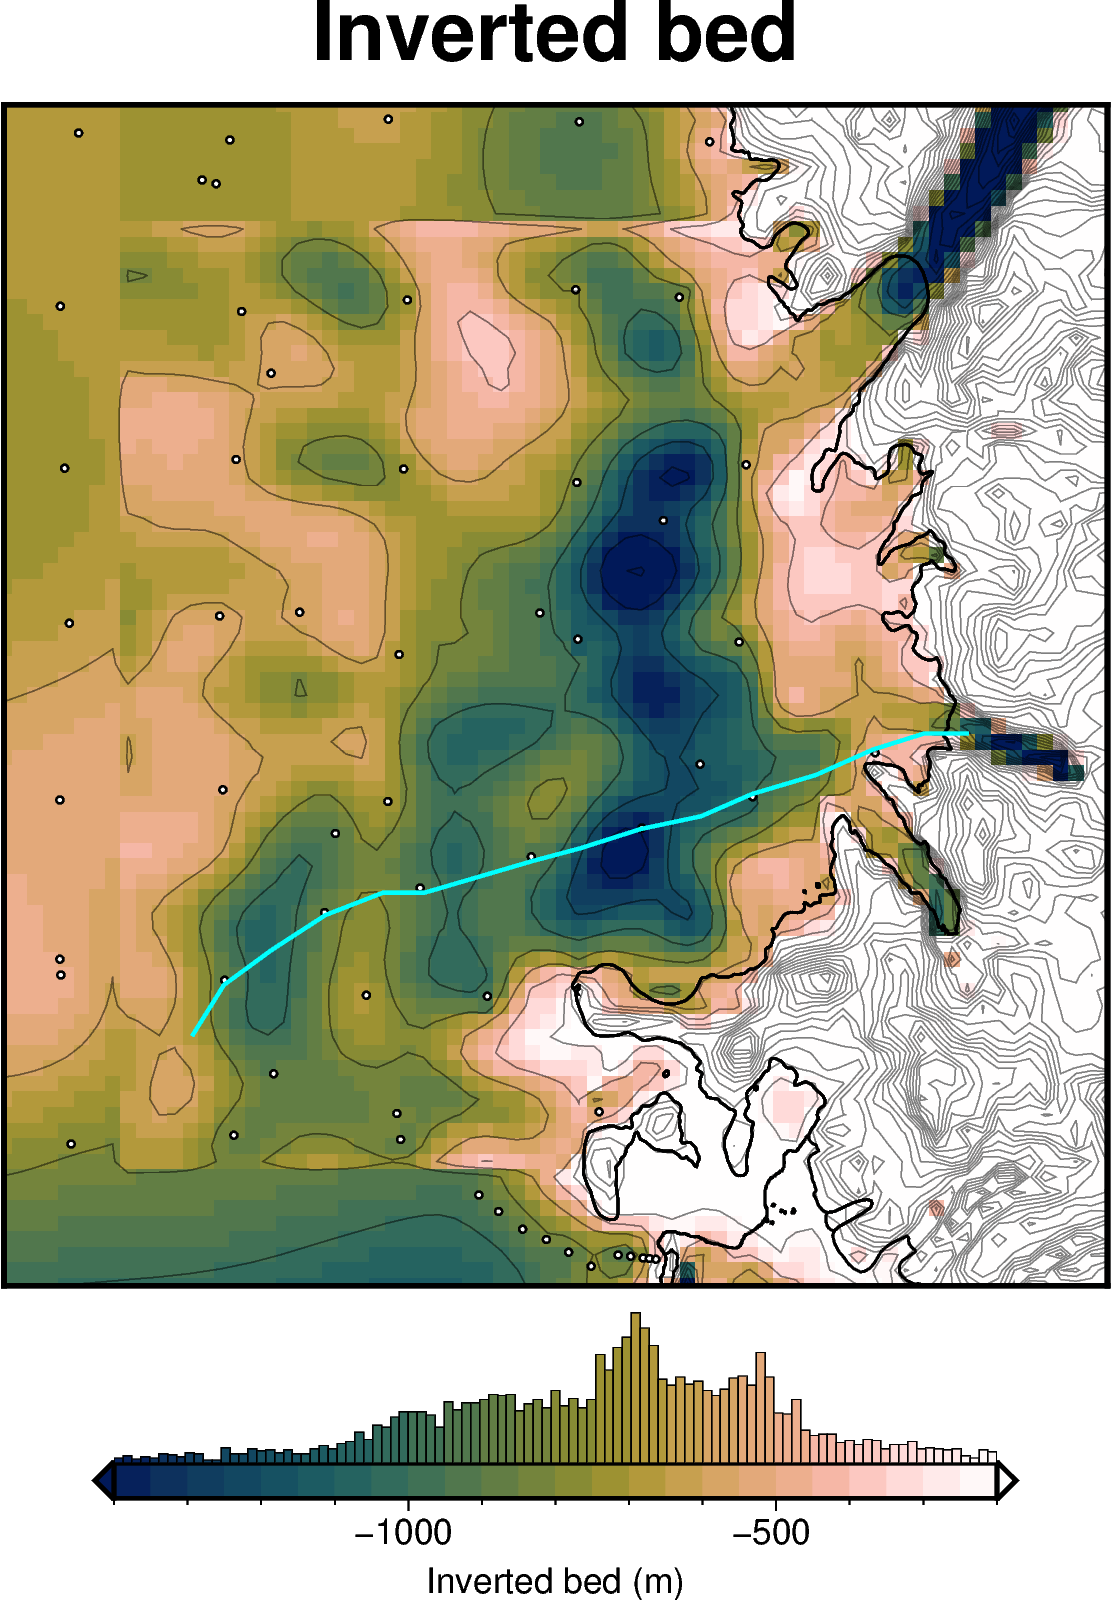

In [224]:
ds = results[0].set_index(["northing", "easting"]).to_xarray()
cols = [s for s in results[0].columns.to_list() if "_layer" in s]
final_bed = ds[cols[-1]]

lims = [-1400, -200]
pygmt.grd2cpt(
    grid=final_bed,
    cmap="batlowW",
    # reverse=True,
    limit=lims,
    nlevels=25,  # background=True,
    output="../../plotting/tmp.cpt",
)

fig = maps.plot_grd(
    final_bed,
    fig_height=10,
    coast=True,
    # coast_version="measures-v2",
    region=buffer_region,
    # cmap="rain",
    cmap="../../plotting/tmp.cpt",
    # reverse_cpt=True,
    title="Inverted bed",
    # title="Inverted bed (verde Spline)",
    # title="Inverted bed (GMT surface)",
    # grd2cpt=True,
    # cpt_lims=[-1500, 0],
    cpt_lims=lims,
    cbar_label="Inverted bed (m)",
    hist=True,
    cbar_yoffset=1.5,
    # shading=True,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
fig.grdcontour(
    grid=final_bed,
    interval=200,
    annotation=None,
    transparency=50,
)
# fig.text(
#     x=150e3,
#     y=200,
#     text="Discovery Deep",
#     font="12p,Helvetica,black",
#     justify="CB",
#     no_clip=True,
# )
df = pd.read_csv("../../plotting/disco_deep_traverse_profile.csv")

fig.plot(
    x=df.x,
    y=df.y,
    pen=".9p,cyan",
    label="Disco Deep survey",
)
fig.show()

In [223]:
df

lon        lat  shape_num              x             y
0   172.964107 -78.724781          0  150527.987278 -1.219635e+06
1   172.389707 -78.861073          0  160767.998932 -1.203251e+06
2   171.594795 -78.943296          0  176127.996208 -1.191987e+06
3   170.691250 -79.020375          0  193535.997260 -1.180723e+06
4   169.761600 -79.056276          0  211967.991423 -1.173555e+06
5   169.133480 -79.034034          0  225280.013998 -1.173555e+06
6   168.266305 -79.048720          0  242687.995015 -1.168435e+06
7   167.396986 -79.060906          0  260095.996356 -1.163315e+06
8   166.633164 -79.065832          0  275455.998580 -1.159219e+06
9   165.653500 -79.077744          0  294912.000827 -1.153075e+06
10  164.698011 -79.068454          0  314368.000414 -1.148979e+06
11  163.845119 -79.090883          0  330751.988123 -1.141811e+06
12  162.814537 -79.090982          0  351231.984736 -1.135667e+06
13  161.847294 -79.111156          0  369664.007033 -1.127475e+06
14  161.018709 -79.107841          0  386047.982802 -1.122355e+06
15  160.366875 -79.064594          0  400384.005076 -1.122355e+06

In [225]:
# sample the inverted topography at the constraint points
constraints = utils.sample_grids(
    constraints,
    final_bed,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraints.upward - constraints.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.66 m


## Density CV

In [ ]:
# run a 5-fold cross validation for 8 parameter sets of density
# this performs 40 regional separations and 40 inversions
study, inversion_results = optimization.optimize_inversion_zref_density_contrast_kfolds(
    grav_df=grav_df,
    solver_damping=best_damping,
    constraints_df=constraints,
    density_contrast_limits=(1300, 1800),
    zref=0,
    n_trials=10,
    split_kwargs=dict(
        n_splits=5,
        method="KFold",
    ),
    regional_grav_kwargs=regional_grav_kwargs,
    starting_topography_kwargs=starting_topography_kwargs,
    fname="../../results/RIS_density_cv",
    fold_progressbar=False,
    **kwargs,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# load saved inversion results
with pathlib.Path("../../results/RIS_density_cv_results.pickle").open("rb") as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/RIS_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [ ]:
best_density_contrast = study.best_params["density_contrast"]
print("optimal determined density contrast", best_density_contrast)

optimal determined density contrast 1688.5580627392058


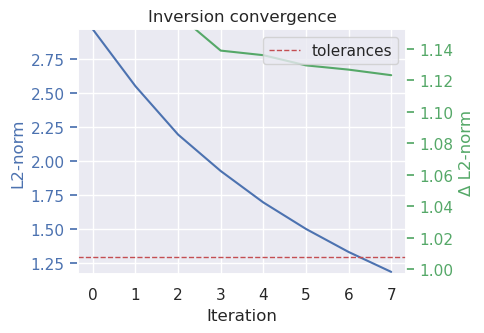

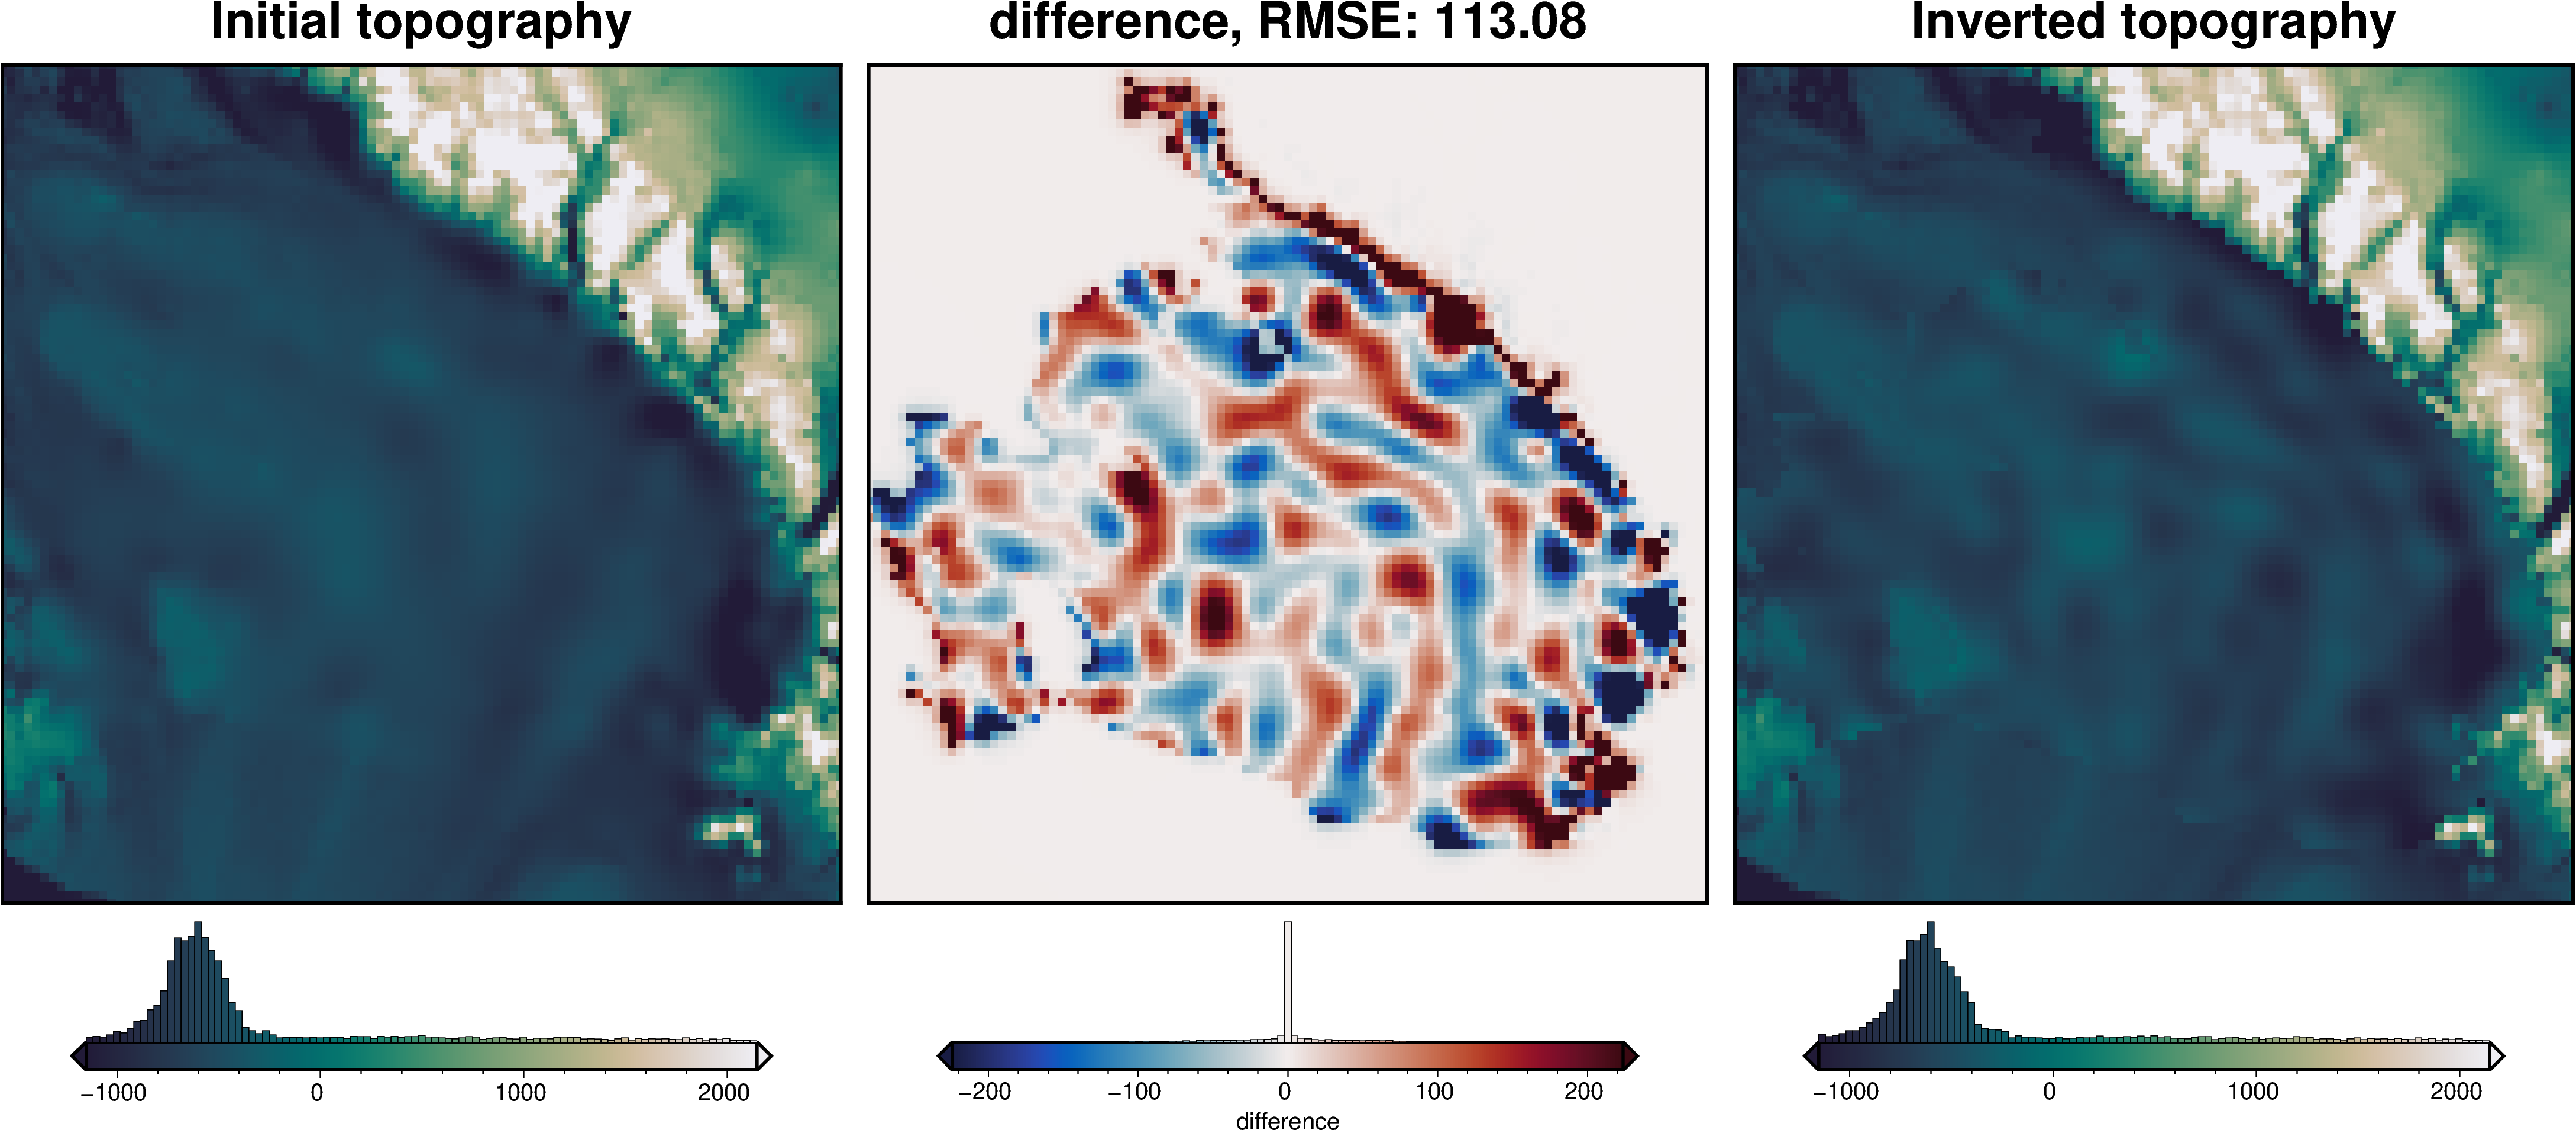

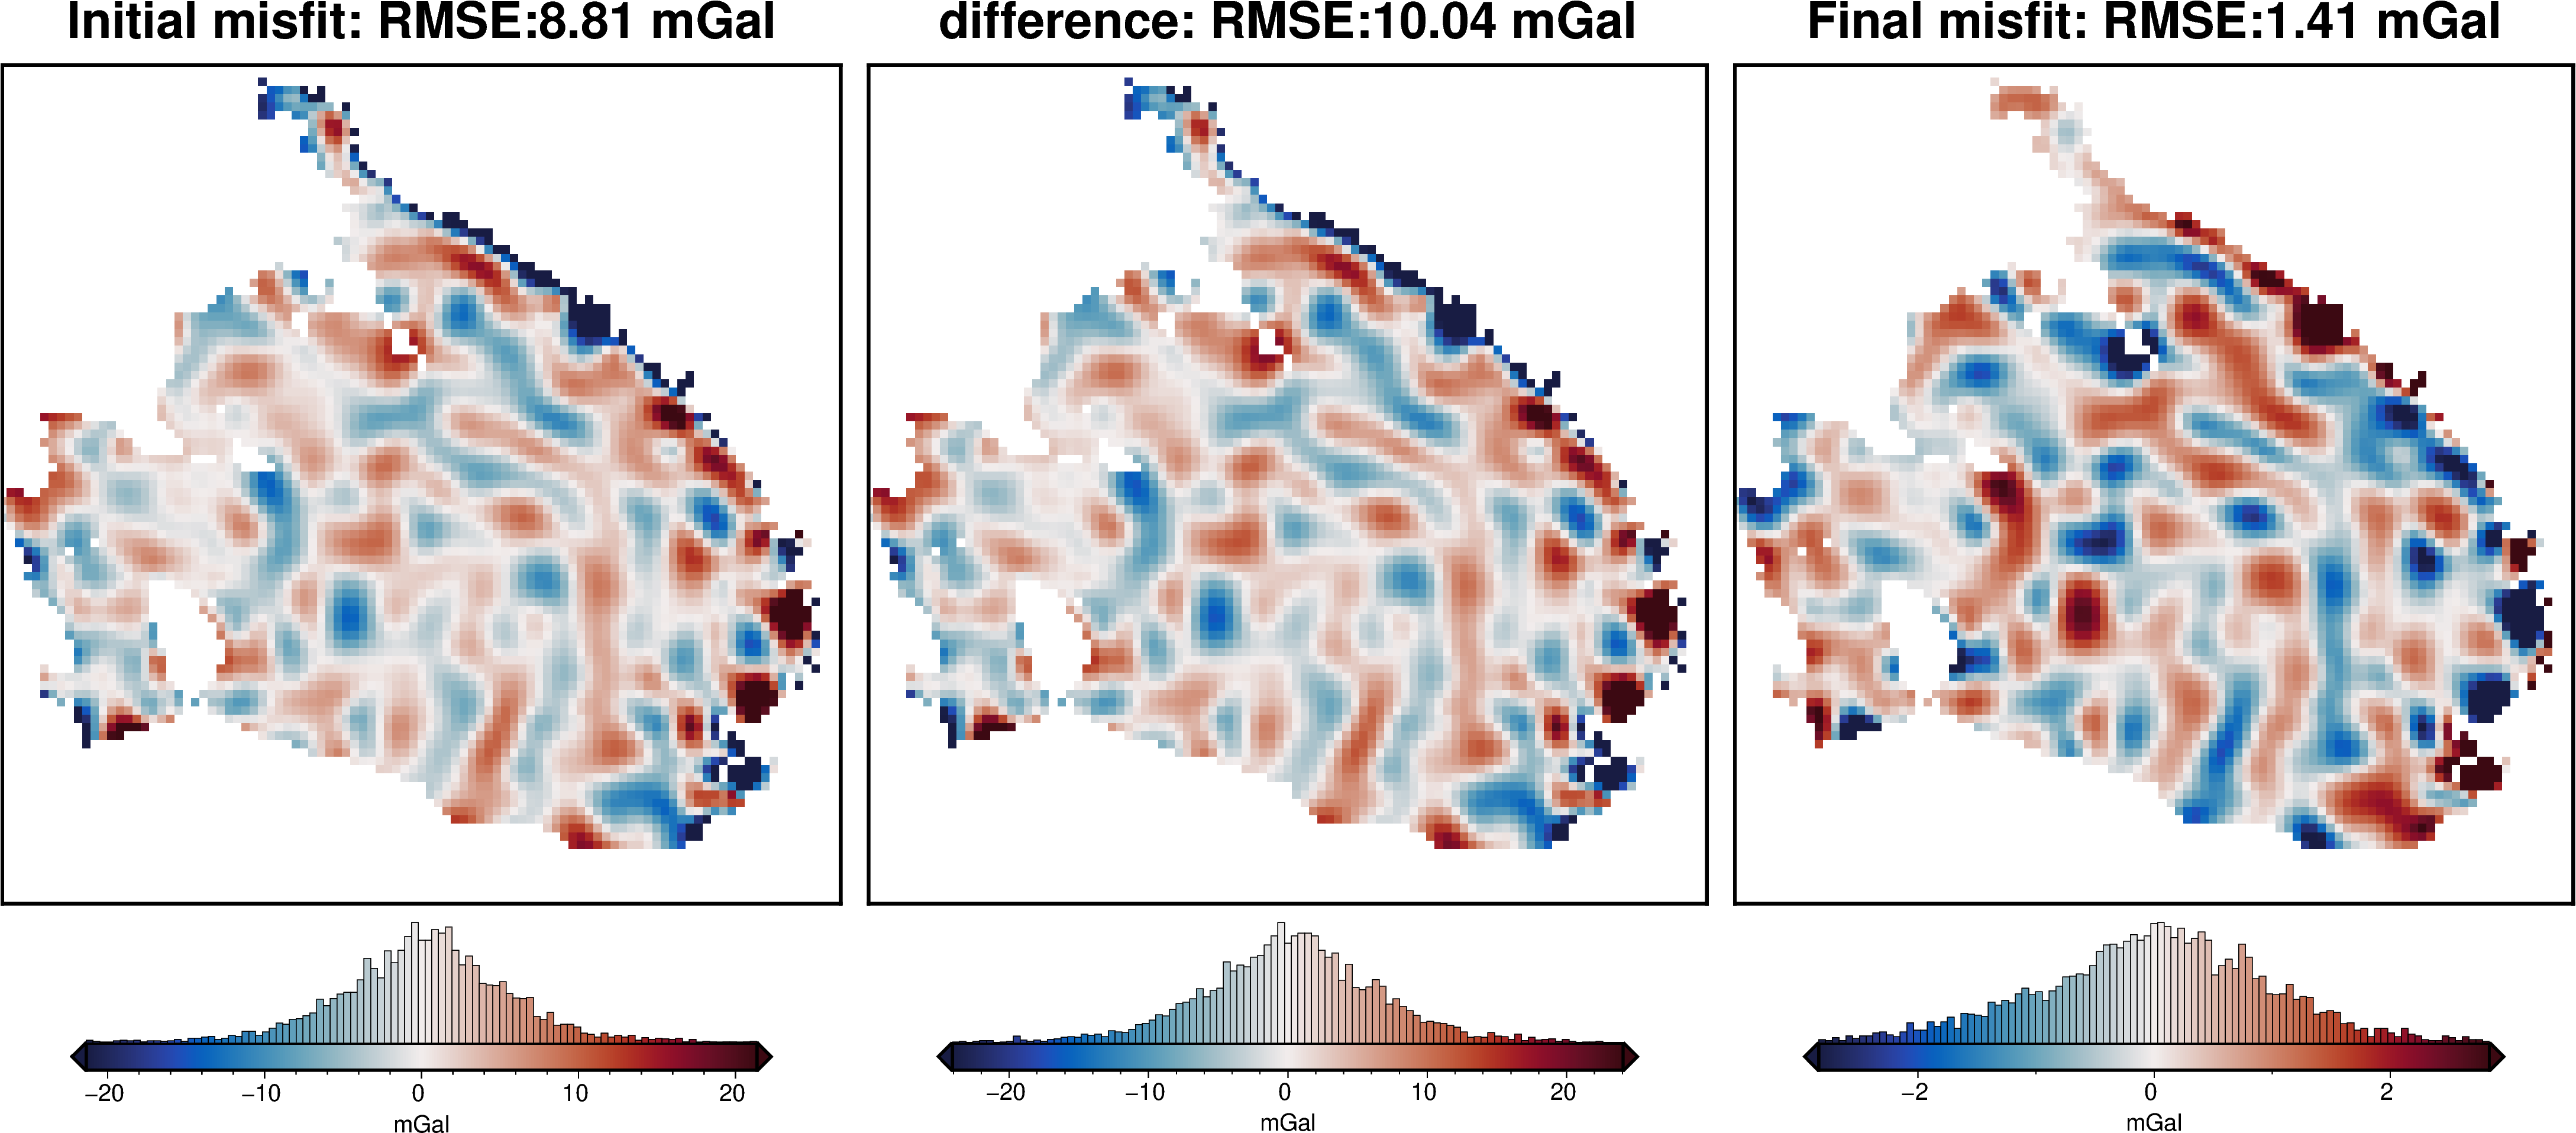

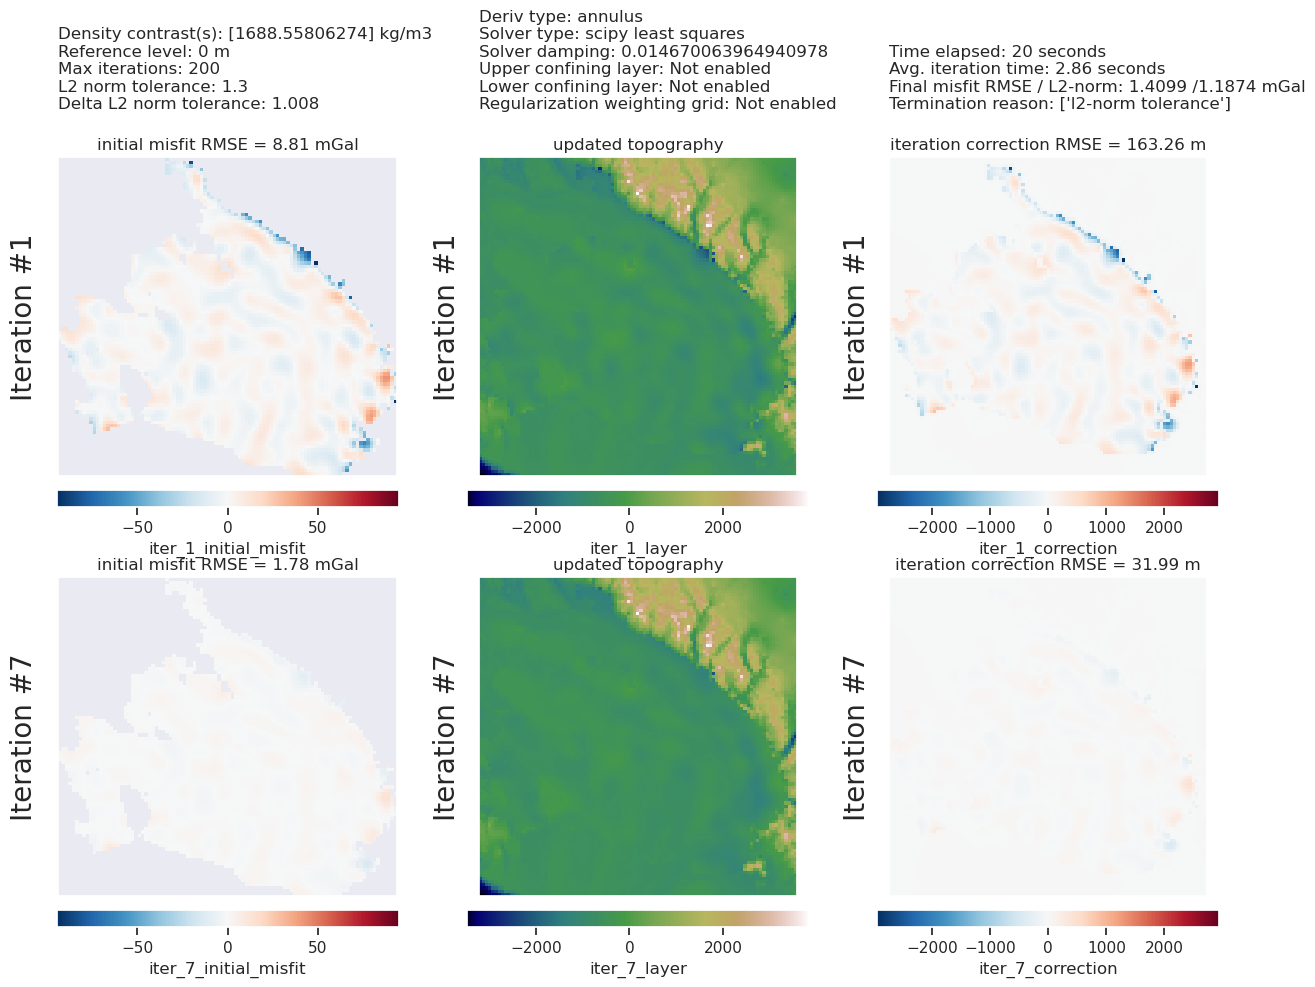

In [ ]:
plotting.plot_convergence(
    grav_results,
    parameters,
)
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

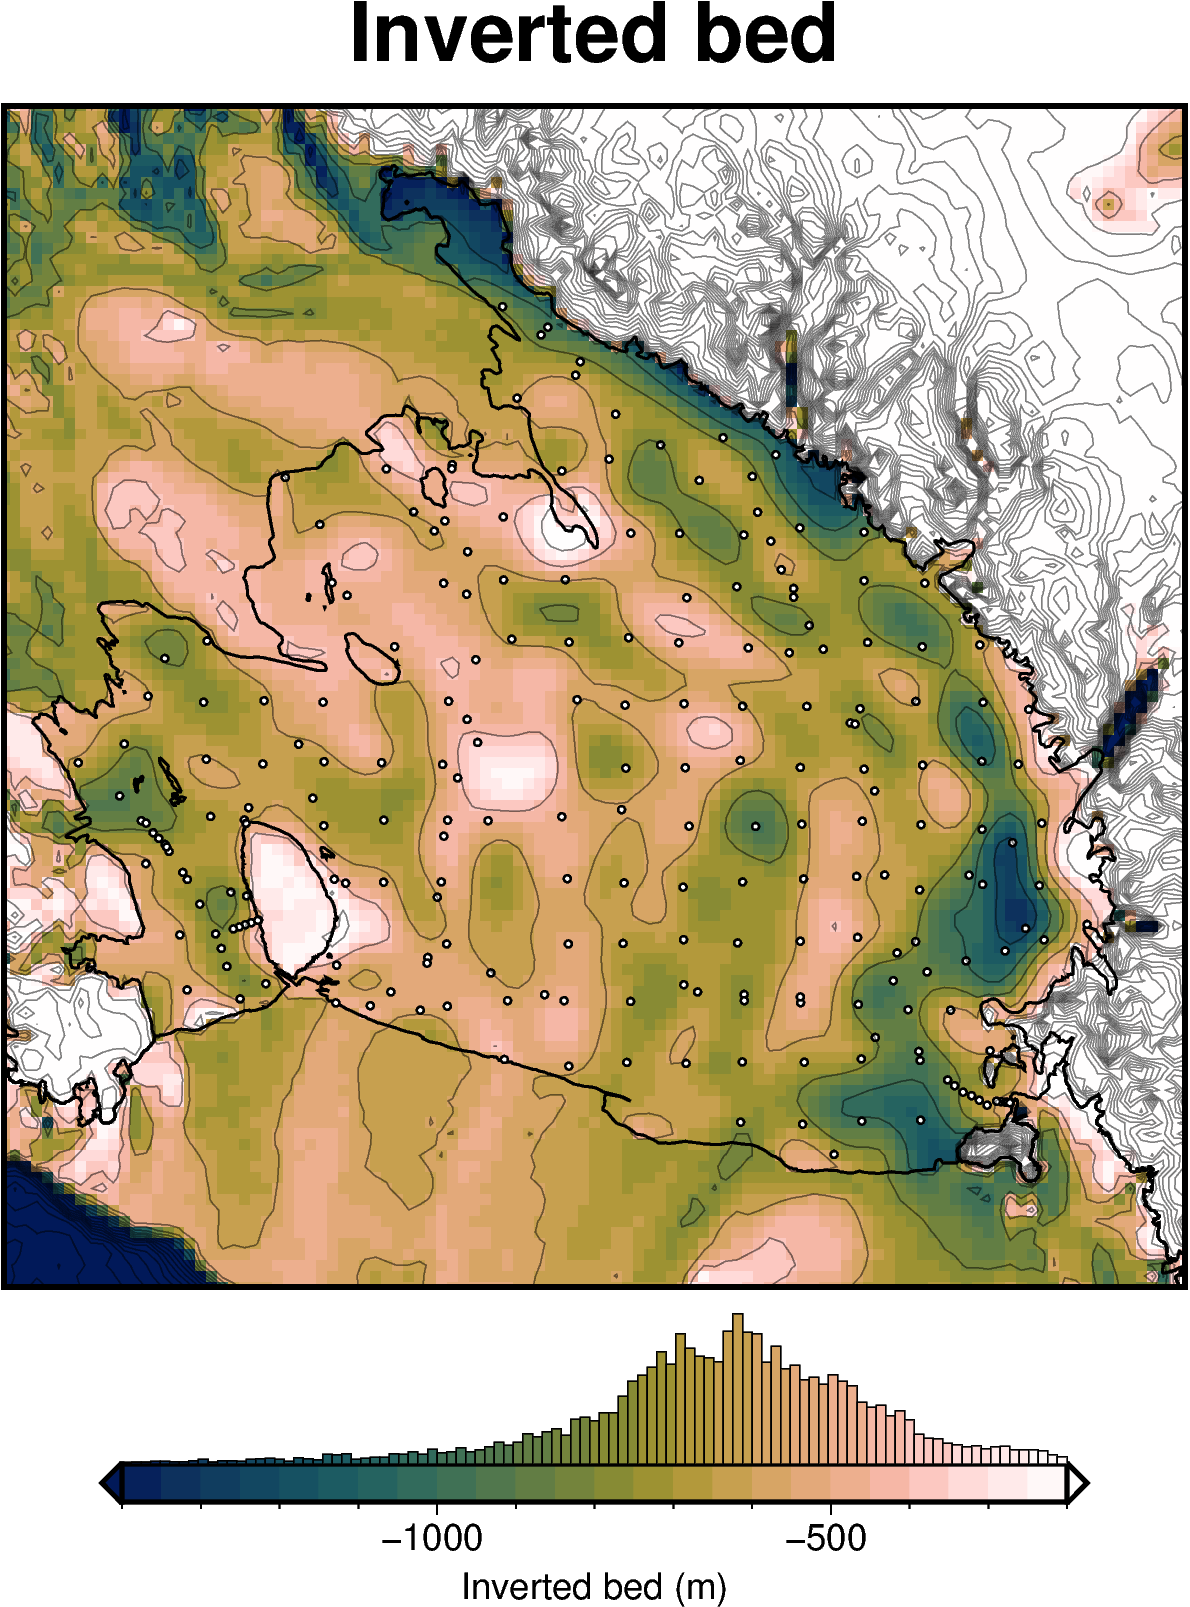

In [ ]:
ds = results[0].set_index(["northing", "easting"]).to_xarray()
cols = [s for s in results[0].columns.to_list() if "_layer" in s]
final_bed = ds[cols[-1]]

lims = [-1400, -200]
pygmt.grd2cpt(
    grid=final_bed,
    cmap="batlowW",
    # reverse=True,
    limit=lims,
    nlevels=25,  # background=True,
    output="../../plotting/tmp.cpt",
)

fig = maps.plot_grd(
    final_bed,
    fig_height=10,
    coast=True,
    coast_version="measures-v2",
    region=buffer_region,
    # cmap="rain",
    cmap="../../plotting/tmp.cpt",
    # reverse_cpt=True,
    title="Inverted bed",
    # title="Inverted bed (verde Spline)",
    # title="Inverted bed (GMT surface)",
    # grd2cpt=True,
    # cpt_lims=[-1500, 0],
    cpt_lims=lims,
    cbar_label="Inverted bed (m)",
    hist=True,
    cbar_yoffset=1.5,
    # shading=True,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
fig.grdcontour(
    grid=final_bed,
    interval=200,
    annotation=None,
    transparency=50,
)

fig.show()

In [ ]:
# sample the inverted topography at the constraint points
constraints = utils.sample_grids(
    constraints,
    final_bed,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraints.upward - constraints.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 19.08 m


In [ ]:
# save to csv
constraints.to_csv("../../results/RIS_constraint_points.csv", index=False)

## Compare with Bedmap2

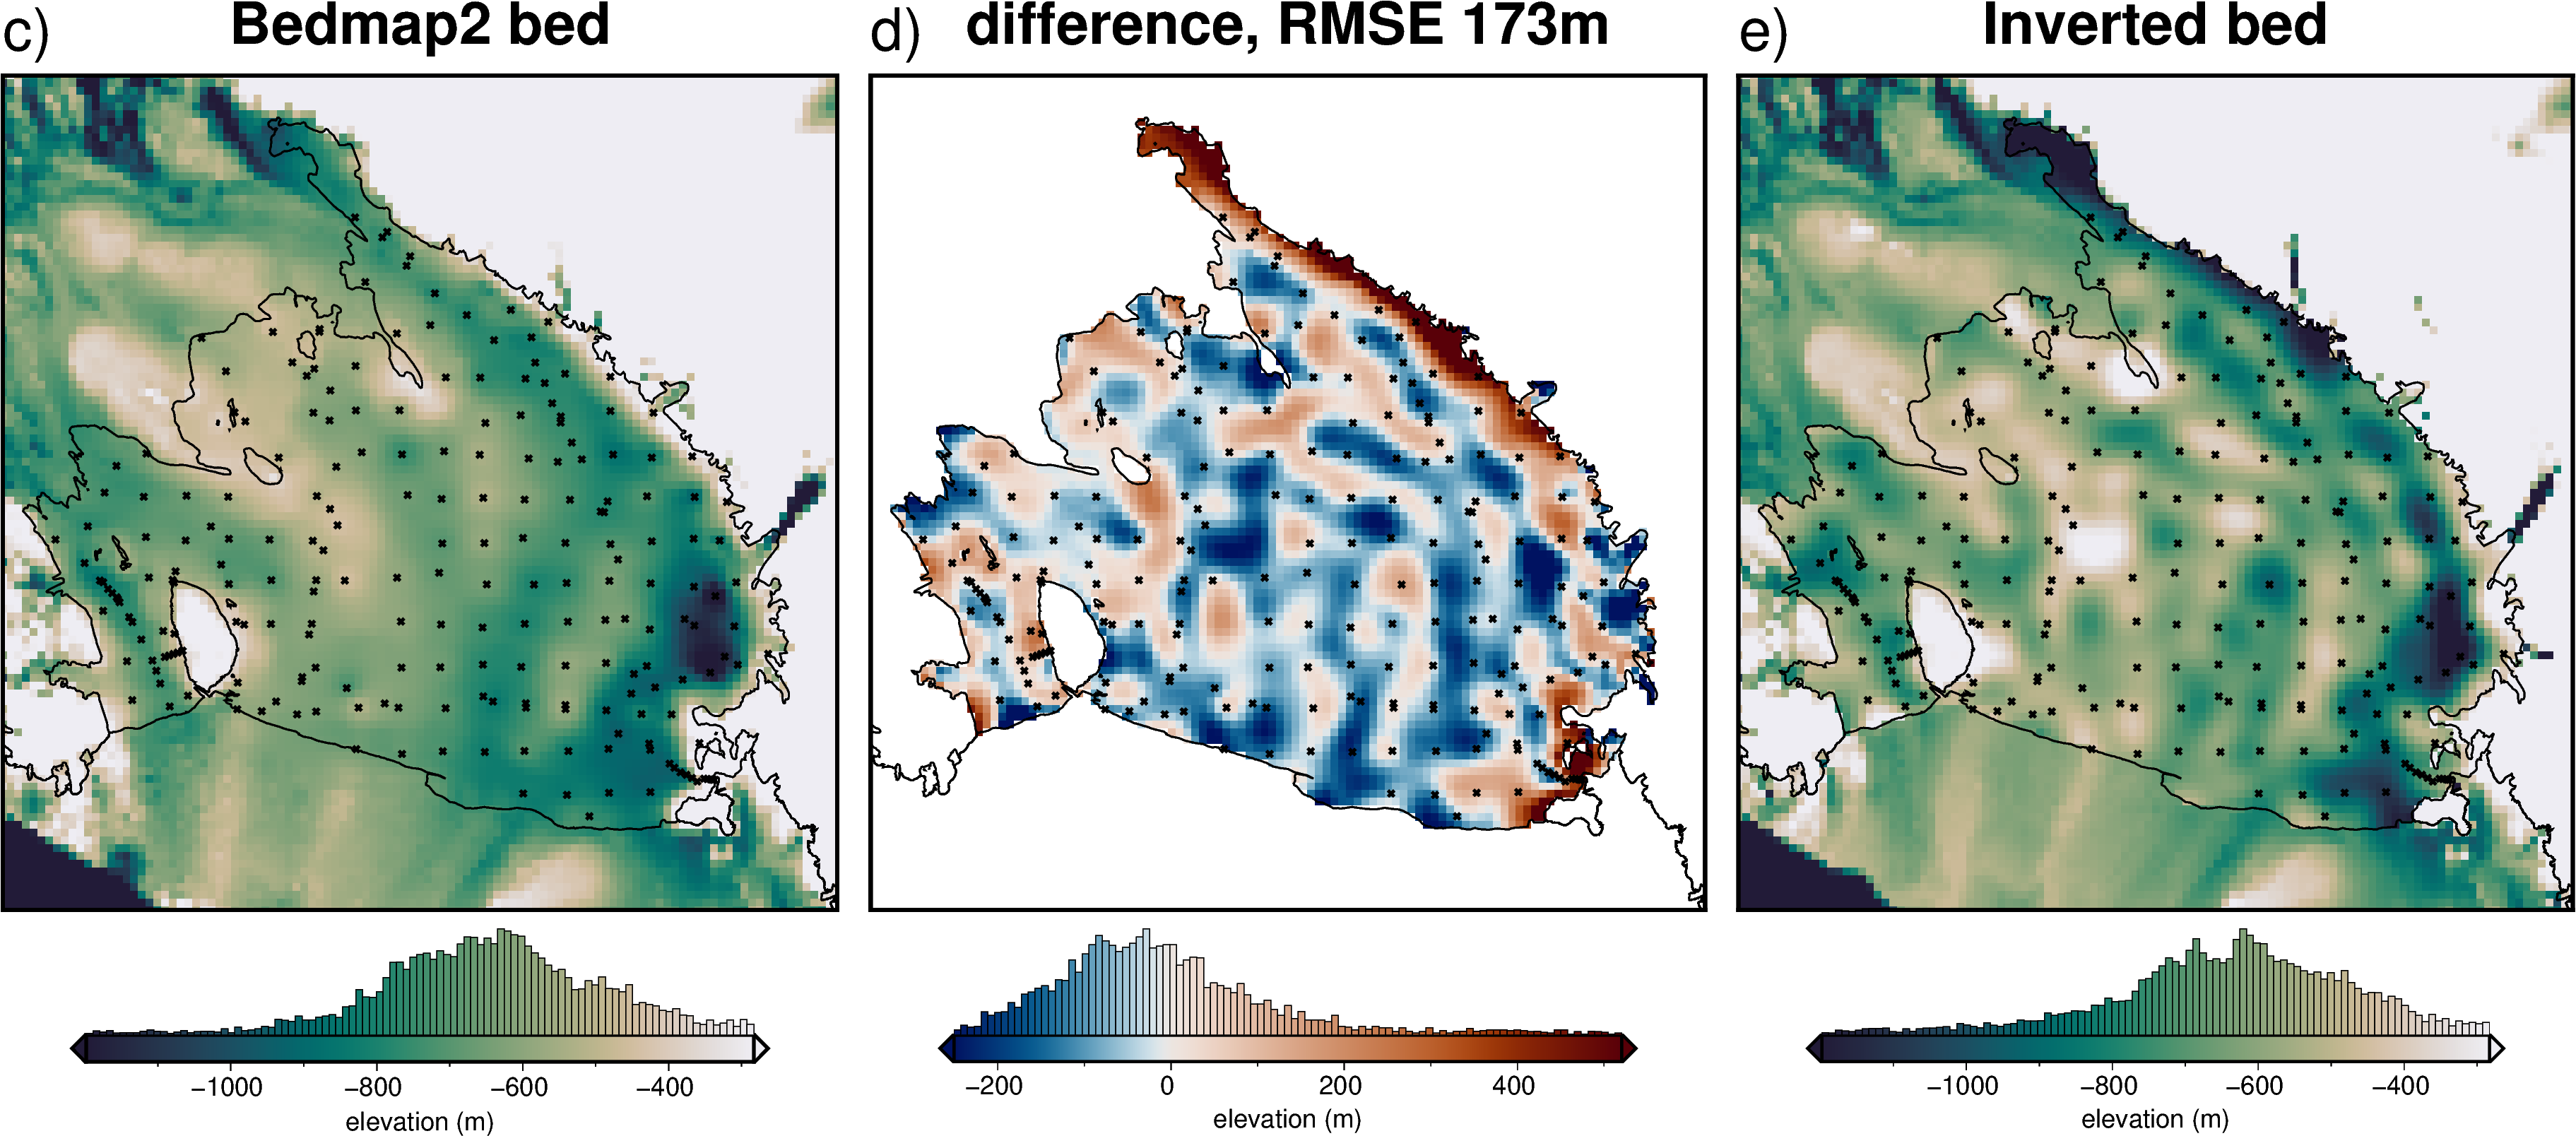

In [106]:
masked_final_bed = polar_utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=final_bed,
    masked=True,
    invert=False,
)
masked_bedmap_bed = polar_utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bedmap_bed,
    masked=True,
    invert=False,
)
masked_dif = masked_bedmap_bed - masked_final_bed
rmse = utils.rmse(masked_dif)

# set color limits
lims = polar_utils.get_min_max(
    masked_final_bed,
    "../../plotting/RIS_outline.shp",
    robust=True,
)

dif = bedmap_bed - final_bed

fig = maps.plot_grd(
    bedmap_bed,
    fig_height=10,
    cmap="rain",
    coast=True,
    coast_version="measures-v2",
    reverse_cpt=True,
    points=constraints[constraints.inside],
    points_style="x0.1c",
    title="Bedmap2 bed",
    cbar_label="elevation (m)",
    cpt_lims=lims,
    robust=True,
    hist=True,
    cbar_yoffset=1.5,
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="20p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig = maps.plot_grd(
    masked_dif,
    fig_height=10,
    points=constraints[constraints.inside],
    cmap="vik+h0",
    coast=True,
    coast_version="measures-v2",
    points_style="x0.1c",
    hist=True,
    cbar_yoffset=1.5,
    title=f"difference, RMSE {int(rmse)}m",
    cbar_label="elevation (m)",
    robust=True,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="d)",
    font="20p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig = maps.plot_grd(
    final_bed,
    fig_height=10,
    points=constraints[constraints.inside],
    cmap="rain",
    coast=True,
    coast_version="measures-v2",
    reverse_cpt=True,
    points_style="x0.1c",
    hist=True,
    cbar_yoffset=1.5,
    title="Inverted bed",
    cbar_label="elevation (m)",
    cpt_lims=lims,
    robust=True,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    justify="BL",
    text="e)",
    font="20p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)
fig.show()

## Compare with starting

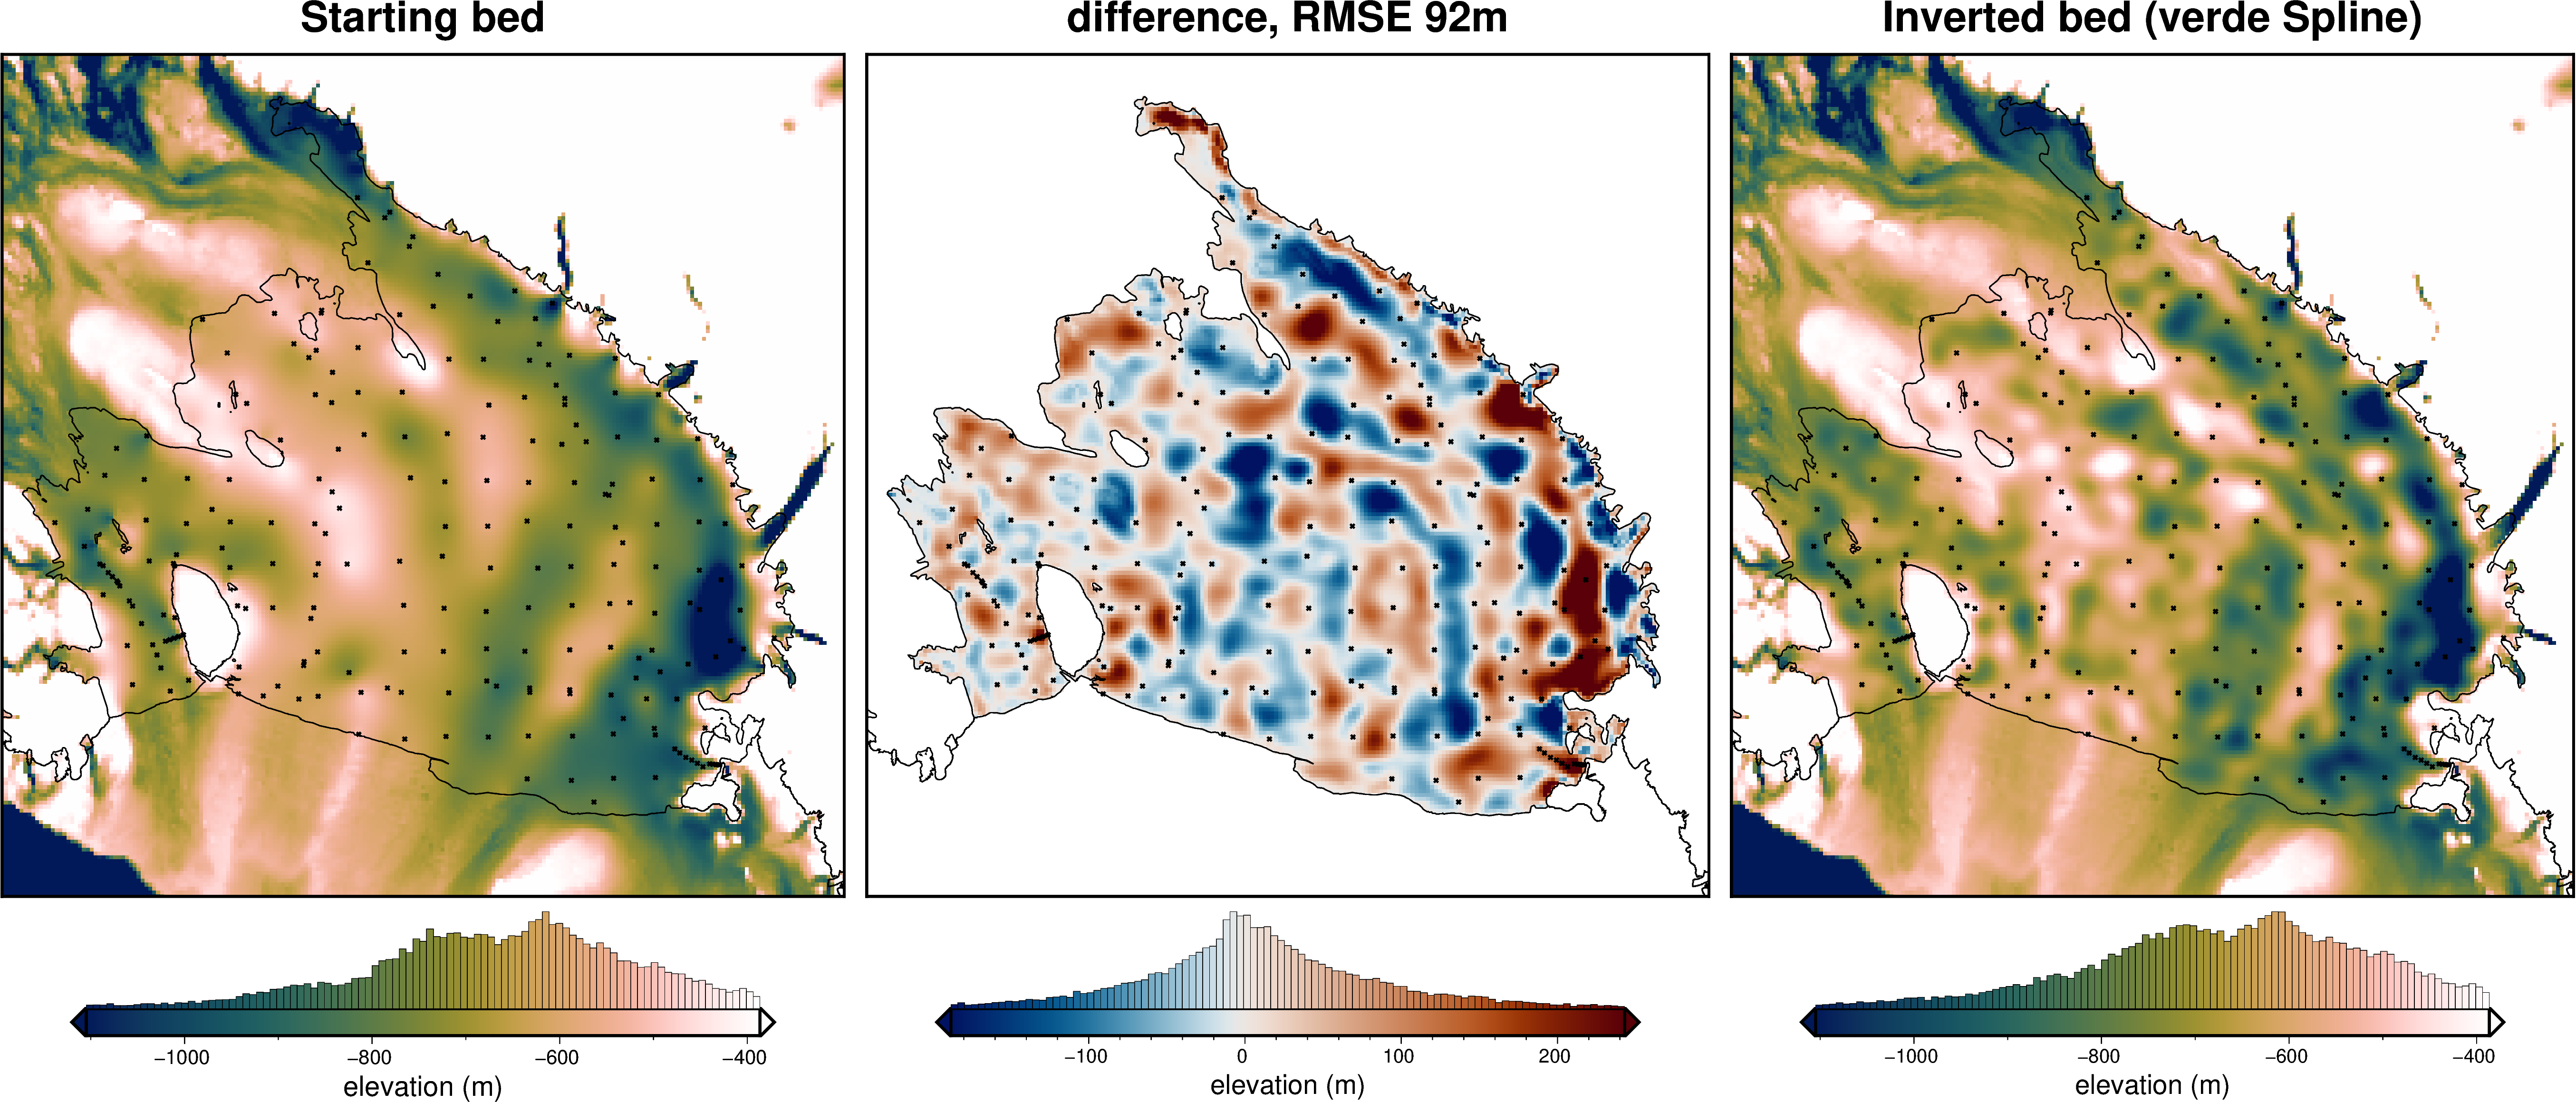

In [54]:
ds = inv_result[0].set_index(["northing", "easting"]).to_xarray()
cols = [s for s in inv_result[0].columns.to_list() if "_layer" in s]
final_bed = ds[cols[-1]]

masked_final_bed = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=final_bed,
    masked=True,
    invert=False,
)
masked_bedmachine_bed = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bedmachine_bed,
    masked=True,
    invert=False,
)
masked_dif = masked_bedmachine_bed - masked_final_bed
rmse = inv_utils.RMSE(masked_dif)

# set color limits
lims = utils.get_min_max(
    masked_final_bed,
    "../../plotting/RIS_outline.shp",
    robust=True,
)

dif = starting_bed - final_bed

fig = maps.plot_grd(
    starting_bed,
    cmap="batlowW",
    coast=True,
    coast_version="measures-v2",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    title="Starting bed",
    cbar_label="elevation (m)",
    cpt_lims=lims,
    robust=True,
    hist=True,
)
fig = maps.plot_grd(
    masked_dif,
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    cmap="vik+h0",
    coast=True,
    coast_version="measures-v2",
    points_style="x0.1c",
    hist=True,
    title=f"difference, RMSE {int(rmse)}m",
    cbar_label="elevation (m)",
    robust=True,
    fig=fig,
    origin_shift="xshift",
)
fig = maps.plot_grd(
    final_bed,
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    cmap="batlowW",
    coast=True,
    coast_version="measures-v2",
    points_style="x0.1c",
    hist=True,
    title="Inverted bed (verde Spline)",
    # title="Inverted bed (GMT surface)",
    cbar_label="elevation (m)",
    cpt_lims=lims,
    robust=True,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

## Compare with Bedmachine

In [ ]:
ds = inv_result[0].set_index(["northing", "easting"]).to_xarray()
cols = [s for s in inv_result[0].columns.to_list() if "_layer" in s]
final_bed = ds[cols[-1]]

masked_final_bed = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=final_bed,
    masked=True,
    invert=False,
)
masked_bedmachine_bed = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bedmachine_bed,
    masked=True,
    invert=False,
)
masked_dif = masked_bedmachine_bed - masked_final_bed
rmse = inv_utils.RMSE(masked_dif)

# set color limits
lims = utils.get_min_max(
    masked_final_bed,
    "../../plotting/RIS_outline.shp",
    robust=True,
)

dif = bedmachine_bed - final_bed

fig = maps.plot_grd(
    bedmachine_bed,
    cmap="rain",
    coast=True,
    coast_version="measures-v2",
    reverse_cpt=True,
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    title="Bedmachine bed",
    cbar_label="elevation (m)",
    cpt_lims=lims,
    robust=True,
    hist=True,
)
fig = maps.plot_grd(
    dif,
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    cmap="vik+h0",
    coast=True,
    coast_version="measures-v2",
    points_style="x0.1c",
    hist=True,
    title=f"difference, RMSE {int(rmse)}m",
    cbar_label="elevation (m)",
    robust=True,
    fig=fig,
    origin_shift="xshift",
)
fig = maps.plot_grd(
    final_bed,
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    cmap="rain",
    coast=True,
    coast_version="measures-v2",
    reverse_cpt=True,
    points_style="x0.1c",
    hist=True,
    title="Inverted bed (verde Spline)",
    # title="Inverted bed (GMT surface)",
    cbar_label="elevation (m)",
    cpt_lims=lims,
    robust=True,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

# Timing and profiles

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="partial_topo_corrected_disturbance",
    prism_layer=starting_bed_prisms,
    max_iterations=50,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    solver_damping=10 ^ -2,
    plot_convergence=True,
    upper_confining_layer=icebase_layer_spacing,
)

In [ ]:
%%prun -q -T results/profiling.txt -D results/profiling-raw.dat
# with inv_utils.HiddenPrints():
inv_result = inv.geo_inversion(
    input_grav=df_anomalies[df_anomalies.test == False],
    **kwargs,
)

In [ ]:
!head -n 20 results/profiling.txt

In [ ]:
import pstats


def filter_profiling(keys, fname):
    output = f"../../results/{fname}"
    with Path.open(output, "w") as f:
        # Load the profiling data and set the output file
        st = pstats.Stats("../../results/profiling-raw.dat", stream=f)
        # Filter the data to isolate the time in the desired
        # function and print to the file
        st.sort_stats("cumtime").reverse_order().print_stats(*keys)
    # Print the file contents
    !cat $output

In [ ]:
filter_profiling(["scipy", "sparse", "lsqr"], "profiling-linsys.txt")

In [ ]:
filter_profiling(["numpy", "dot"], "profiling-dot.txt")

In [ ]:
filter_profiling(["harmonica", "jit_prism_gravity"], "profiling-forward.txt")

In [ ]:
keys = "forward dot linsys".split()
times = {}
total_times = []
for k in keys:
    with Path.open(f"../../results/profiling-{k}.txt") as f:
        lines = f.readlines()
    times[k] = float(lines[-3].strip().split()[3])
    total_times.append(float(lines[2].strip().split()[-2]))
# Check if all total execution times read are equal
assert np.all(np.equal(total_times[0], total_times))
total_time = total_times[0]

total_time, times

In [ ]:
percentage = {k: 100 * times[k] / total_time for k in keys}

for k in keys:
    print(f"{k} = {percentage[k]:.5f} %")

In [ ]:
tmp = !cat /proc/cpuinfo | grep "model name"
processor = tmp[0].split(":")[1].strip()
print(processor)

In [ ]:
caption = f"""
        Time spent on each function during a single inversion of
        Ross Ice Shelf bathymetry.
        The inversion was performed on a computer with a
        {processor} processor.
        The total time for the inversion was {total_time:.3f} seconds.
"""
print(caption)

In [ ]:
line = "{func} & {time:.3f} & {percent:.3f}"
lsqr = line.format(
    func="Sparse LSQR", time=times["linsys"], percent=percentage["linsys"]
)
dot = line.format(
    func="Sparse dot product", time=times["dot"], percent=percentage["dot"]
)
fwd = line.format(
    func="Prism forward modeling", time=times["forward"], percent=percentage["forward"]
)
lsqr, dot, fwd

In [ ]:
table = f"""
\begin{{table}}
    \\centering
    \\caption{caption}
    \\label{{profiling}}
    \begin{{tabular}}{{lcc}}
        Function description & Time (s) & Percentage of total time (\\%)\\
        \\hline
        {lsqr}\\
        {dot}\\
        {fwd}\\
        \\hline
    \\end{{tabular}}
\\end{{table}}
"""
print(table)